In [1]:
# Standard Library Imports
import datetime as dt
import os
import pickle
import warnings

# Third-Party Imports
import joblib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from IPython.display import display
from scipy import stats
from scipy.stats import mode, shapiro, ttest_ind, trim_mean
from sklearn.metrics import (accuracy_score, classification_report, f1_score, mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

# Local Imports (if any)
#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

# Set warning filters
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'prophet'

This function returns a DataFrame with information about the percentage of nulls in each column and the column data type.



In [ ]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
train1 = pd.read_csv("train.csv")
test1 = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
sample = pd.read_csv("SampleSubmission.csv")
dates = pd.read_csv("dates.csv")
holidays = pd.read_csv("holidays.csv")

In [ ]:
stores['cluster'] = stores['cluster'].map(lambda x: 'cluster_' + str(x))  # Convert cluster numbers to cluster names
stores['type'] = stores['type'].map(lambda x: 'store_' + str(x))  # Convert store_type numbers to store_type names
stores['city'] = stores['city'].map(lambda x: 'city_' + str(x))  # Convert city numbers to city names

# Display unique values after conversion
print("Unique clusters:", stores['cluster'].unique())
print("Unique store types:", stores['type'].unique())
print("Unique cities:", stores['city'].unique())

Unique clusters: ['cluster_0' 'cluster_1' 'cluster_2' 'cluster_3' 'cluster_4' 'cluster_5'
 'cluster_6' 'cluster_7' 'cluster_8' 'cluster_9' 'cluster_10' 'cluster_11'
 'cluster_12' 'cluster_13' 'cluster_14' 'cluster_15' 'cluster_16']
Unique store types: ['store_0' 'store_1' 'store_2' 'store_3' 'store_4']
Unique cities: ['city_0' 'city_1' 'city_2' 'city_3' 'city_4' 'city_5' 'city_6' 'city_7'
 'city_8' 'city_9' 'city_10' 'city_11' 'city_12' 'city_13' 'city_14'
 'city_15' 'city_16' 'city_17' 'city_18' 'city_19' 'city_20' 'city_21']


In [ ]:
# rename type to store_type to make it more descriptive

stores.rename(columns={'type': 'store_type'}, inplace=True)

In [ ]:
# make each holiday type a string

holidays['type'] = holidays['type'].apply(lambda x: 'holiday_' + str(x))

holidays['type'].value_counts()

type
holiday_0    170
holiday_5     56
holiday_2     38
holiday_1      9
holiday_4      5
holiday_3      3
Name: count, dtype: int64

In [ ]:
# rename type to holiday_type to make it more descriptive

holidays.rename( columns={'type': 'holiday_type'}, inplace=True)


In [ ]:
def get_is_holiday_column(holidays):
  holidays['holiday_type'] = holidays['holiday_type'].fillna('Workday')

  # create column to show if its a holiday or not (non-holidays are zeros)
  holidays['is_holiday'] = holidays['holiday_type'].apply(
      lambda x: False if x=='Workday'
      else True)

In [ ]:
#merging train and test with stores dataset

def merge(df1, df2):
    merged_df = df1.merge(df2, how='left', on='date')

    return merged_df

def merge_stores(df1, df2):
    merged_df = df1.merge(df2, how='left', on='store_id')

    return merged_df

In [ ]:
# Merge train with stores
train_merged = merge_stores(train1, stores)

# Merge the result with holidays
train_merged1 = merge(train_merged, holidays)

get_is_holiday_column(train_merged1)

# Merge the result with dates
train = train_merged1

train.head()

date store_id  category_id  target  onpromotion  nbr_of_transactions  \
0  12/30/1900  store_1  category_24     0.0            0                    0   
1  12/30/1900  store_1  category_21     0.0            0                    0   
2  12/30/1900  store_1  category_32     0.0            0                    0   
3  12/30/1900  store_1  category_18     0.0            0                    0   
4  12/30/1900  store_1  category_26     0.0            0                    0   

     city store_type    cluster holiday_type  is_holiday  
0  city_0    store_0  cluster_0    holiday_0        True  
1  city_0    store_0  cluster_0    holiday_0        True  
2  city_0    store_0  cluster_0    holiday_0        True  
3  city_0    store_0  cluster_0    holiday_0        True  
4  city_0    store_0  cluster_0    holiday_0        True

In [ ]:
# Assuming your DataFrame is named df
train.drop('nbr_of_transactions', axis=1, inplace=True)


In [ ]:
# Convert 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

In [ ]:
train['week_number'] = train['date'].dt.isocalendar().week


In [ ]:

agg_df = train.groupby(['store_id', 'date']).agg({'target': 'sum'}).reset_index().sort_values(['store_id', 'date'])


In [ ]:
total_sales_df = agg_df.pivot(index='date', columns=['store_id'], values='target')


In [ ]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 4 columns due to insufficient data volume.


In [ ]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 6 rows for following category: store_1
Dropping 10 rows for following category: store_10
Dropping 10 rows for following category: store_11
Dropping 9 rows for following category: store_12
Dropping 13 rows for following category: store_13
Dropping 7 rows for following category: store_14
Dropping 9 rows for following category: store_15
Dropping 9 rows for following category: store_16
Dropping 10 rows for following category: store_17
Dropping 13 rows for following category: store_18
Dropping 12 rows for following category: store_19
Dropping 8 rows for following category: store_2
Dropping 12 rows for following category: store_20
Dropping 9 rows for following category: store_23
Dropping 4 rows for following category: store_24
Dropping 11 rows for following category: store_25
Dropping 10 rows for following category: store_26
Dropping 7 rows for following category: store_27
Dropping 7 rows for following category: store_28
Dropping 15 rows for following category: store_29
Dropping 6 r

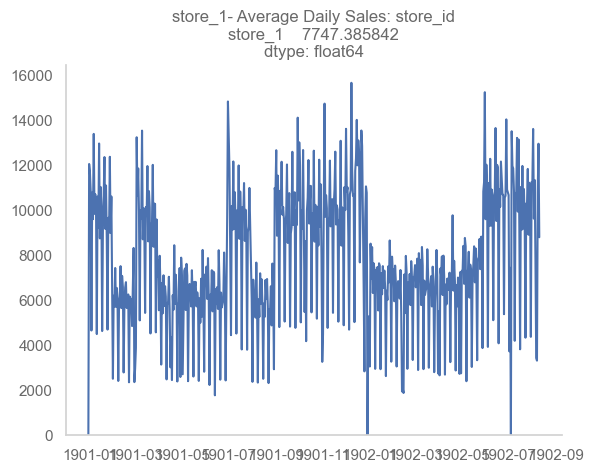

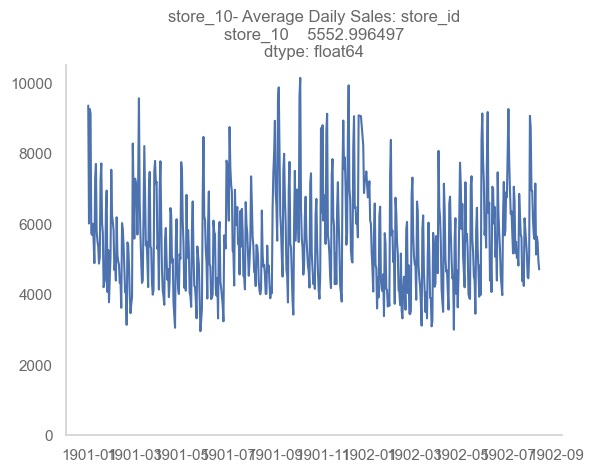

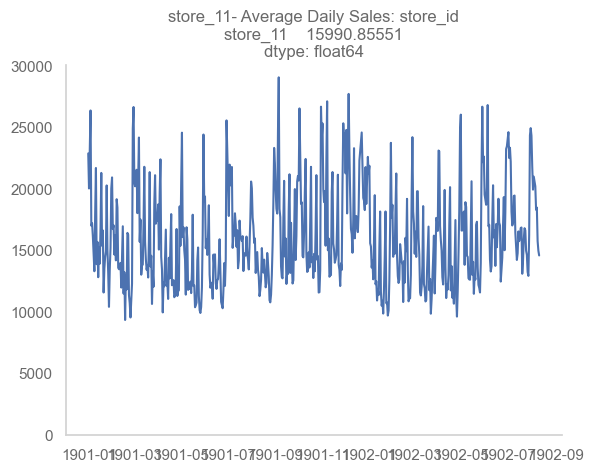

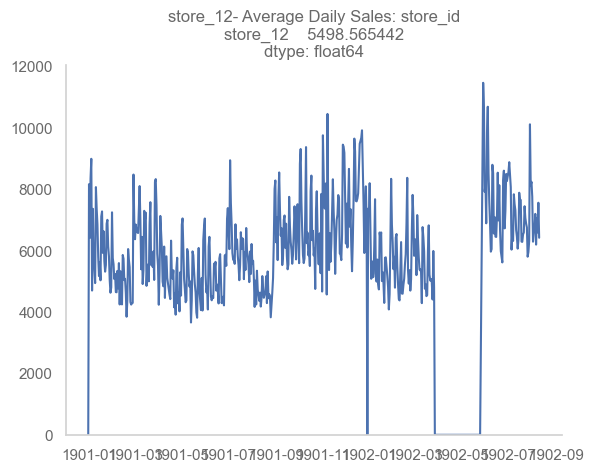

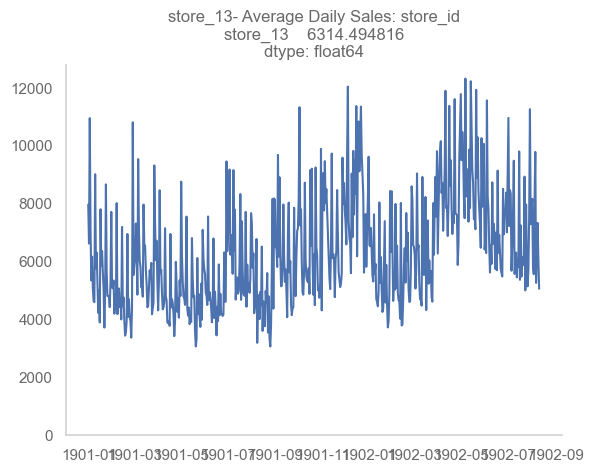

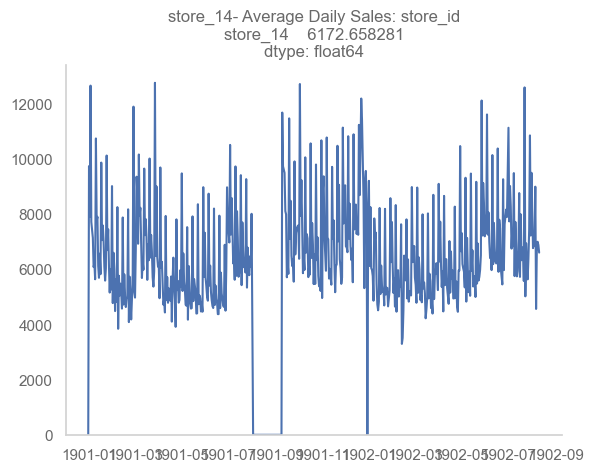

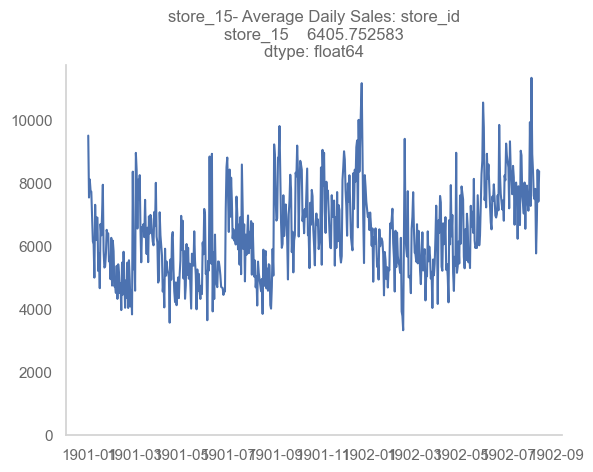

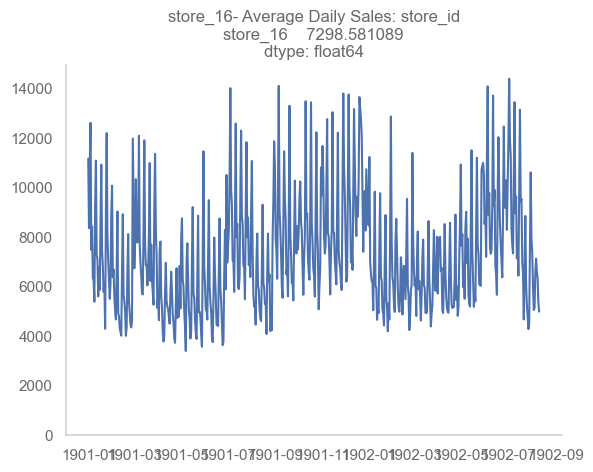

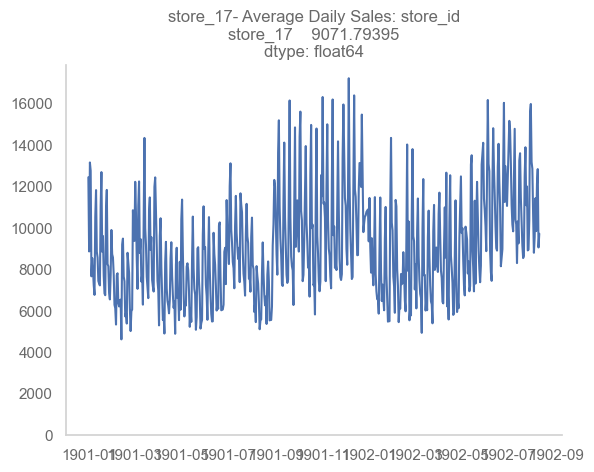

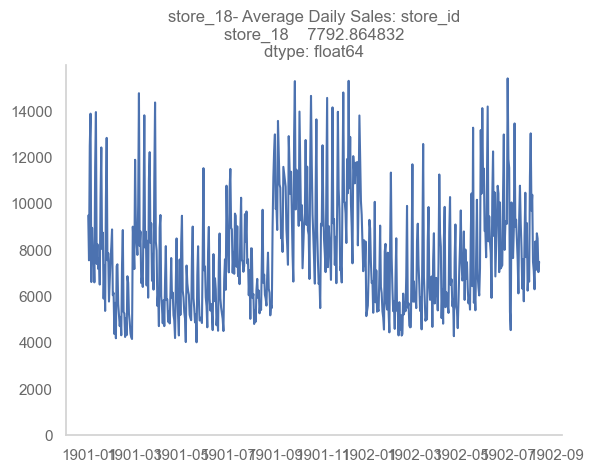

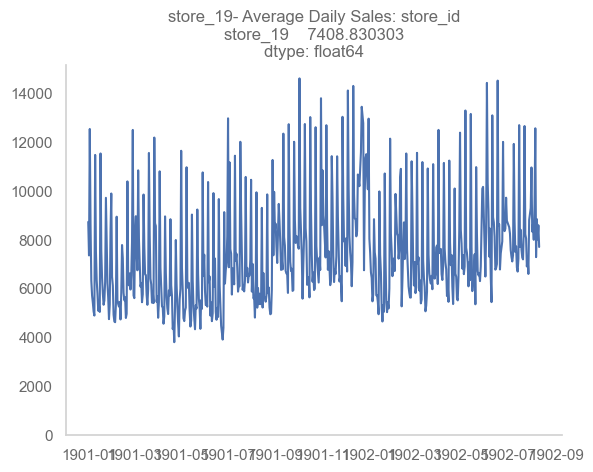

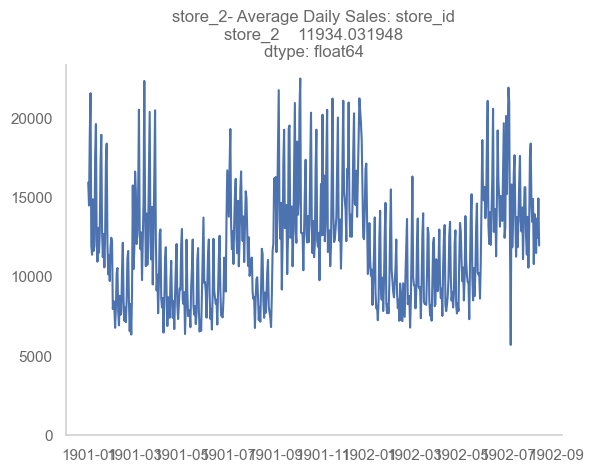

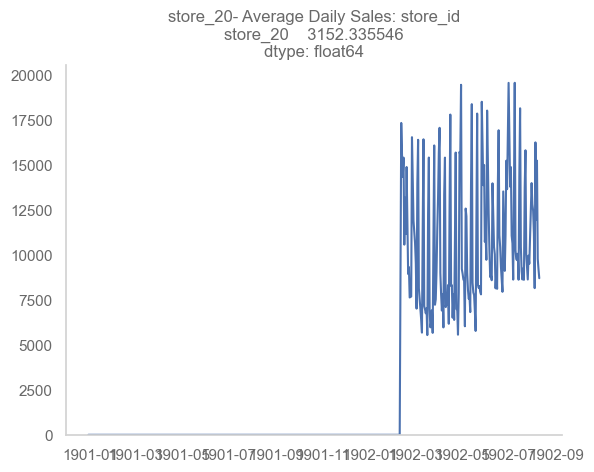

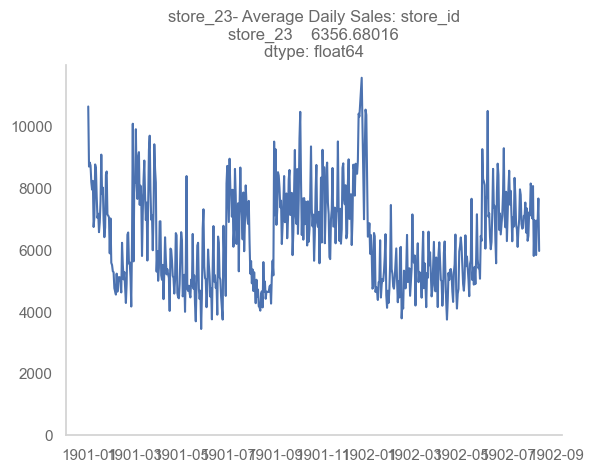

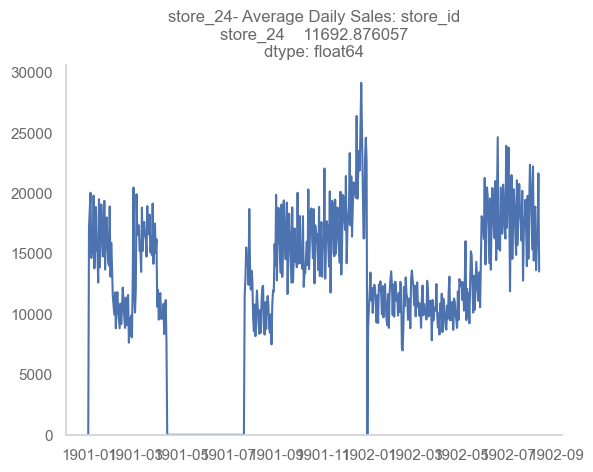

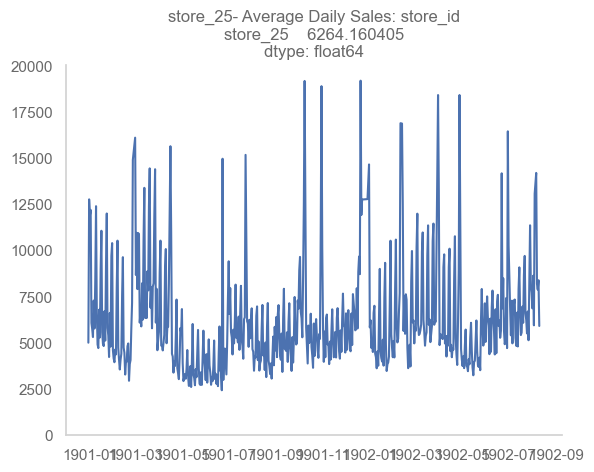

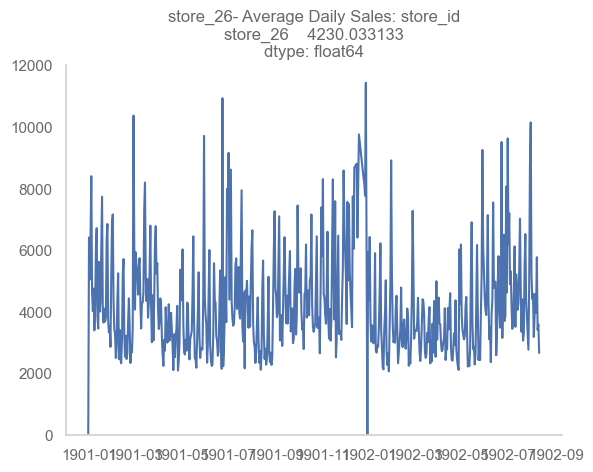

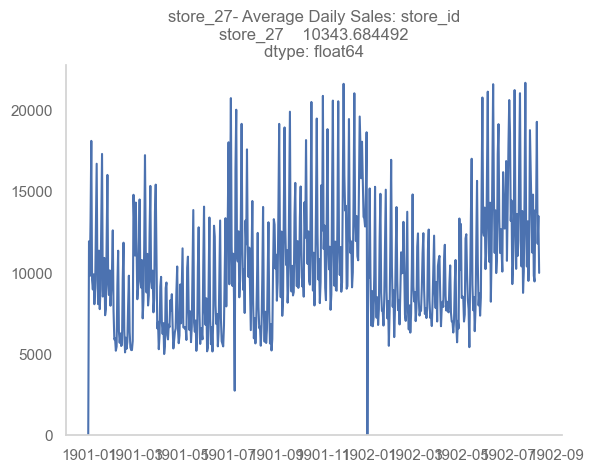

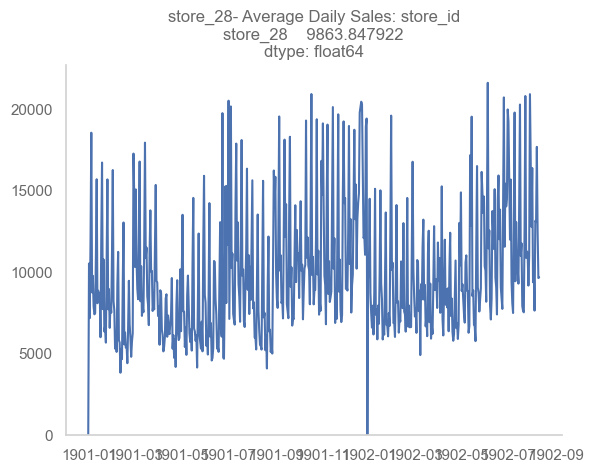

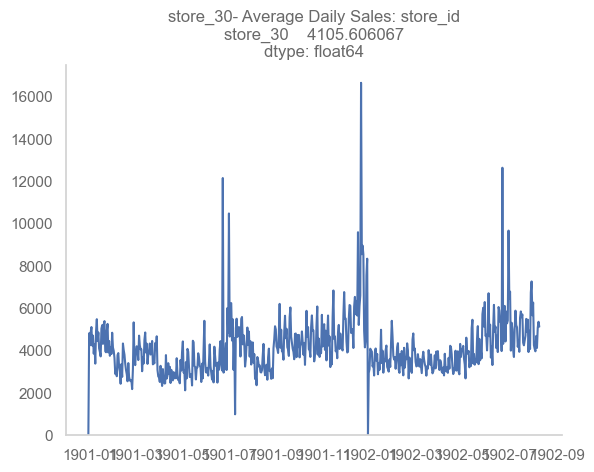

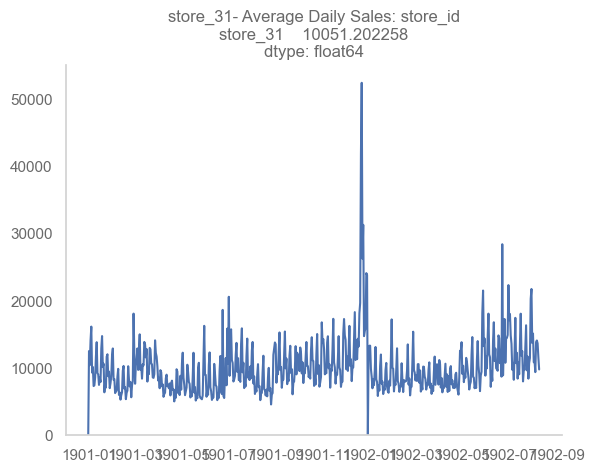

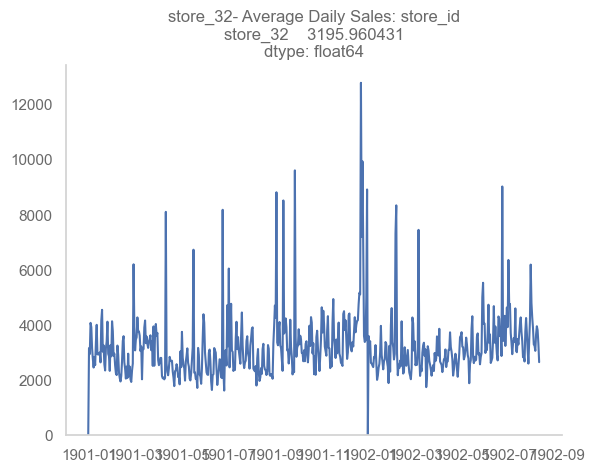

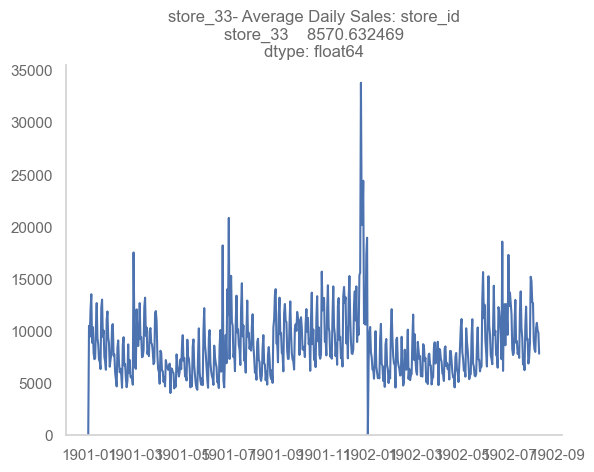

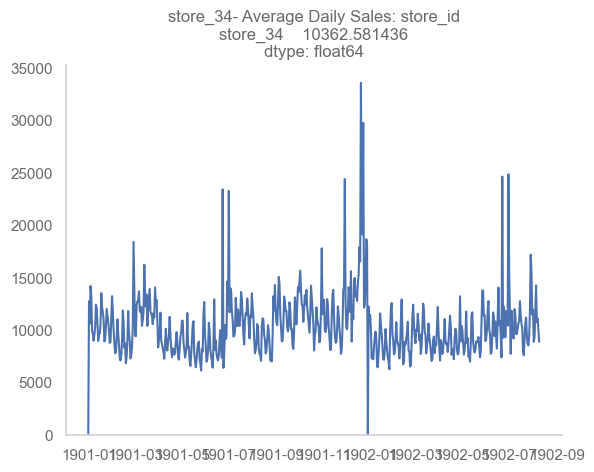

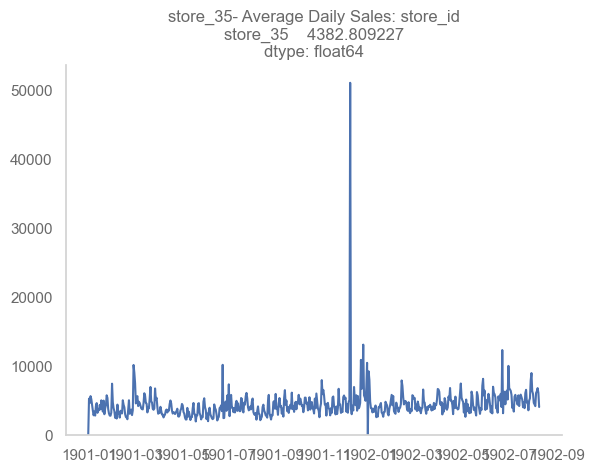

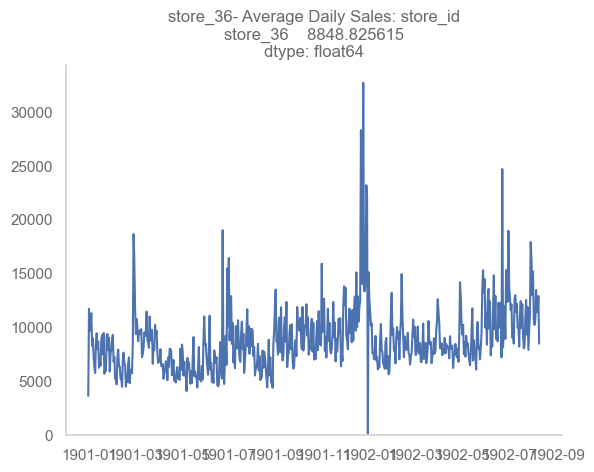

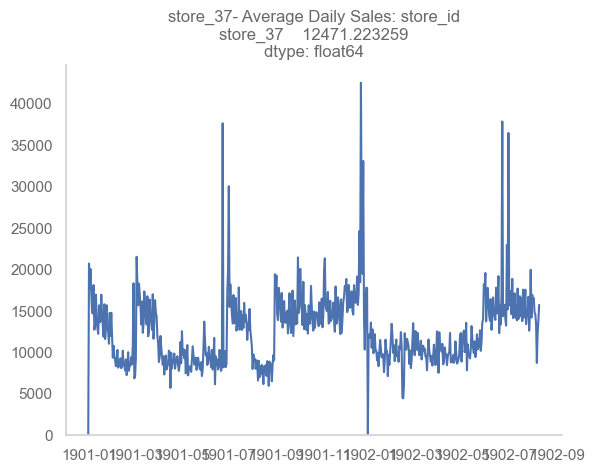

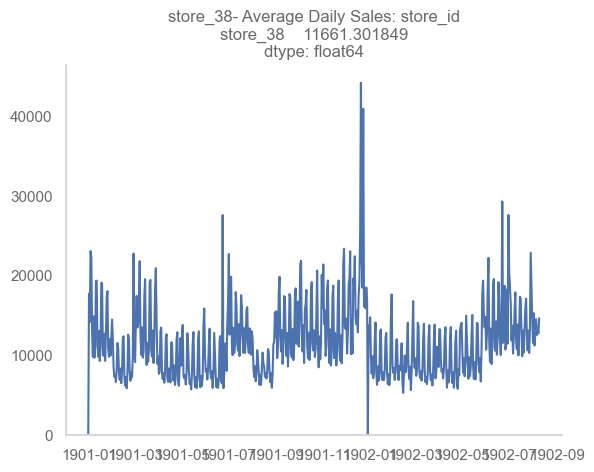

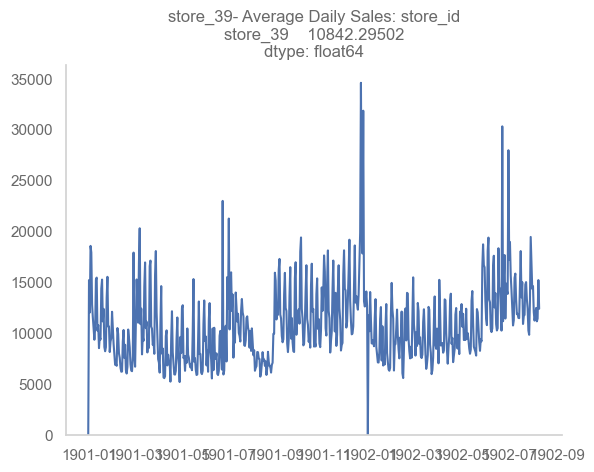

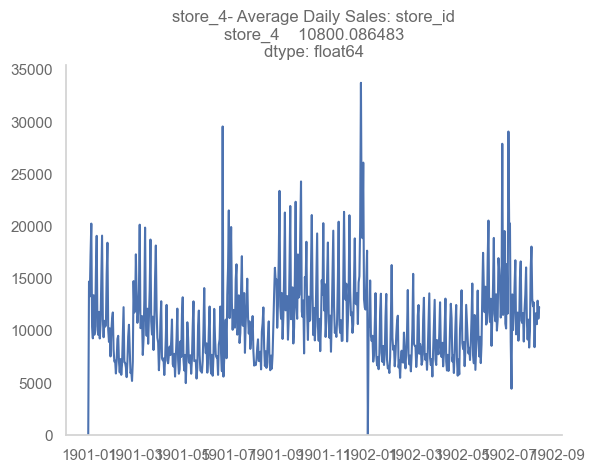

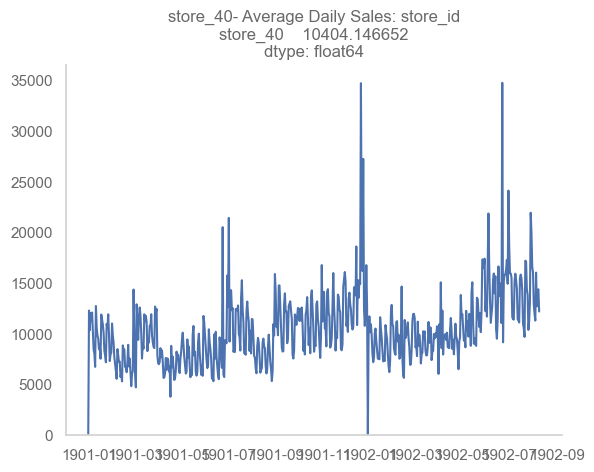

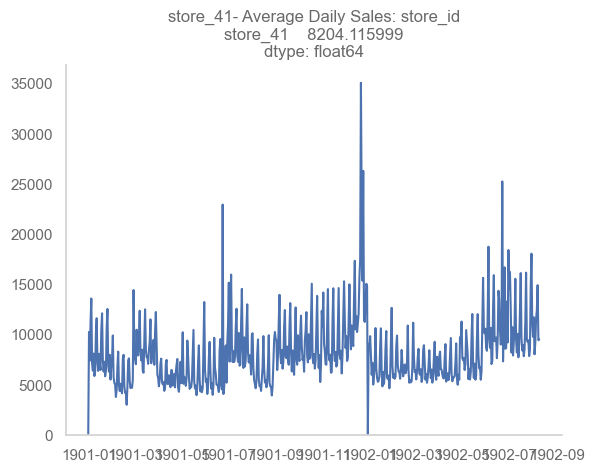

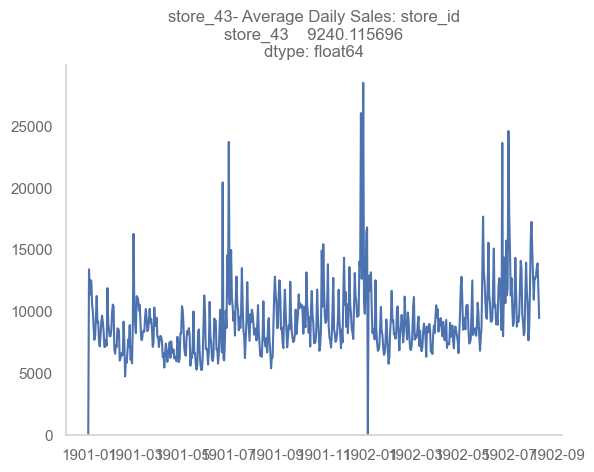

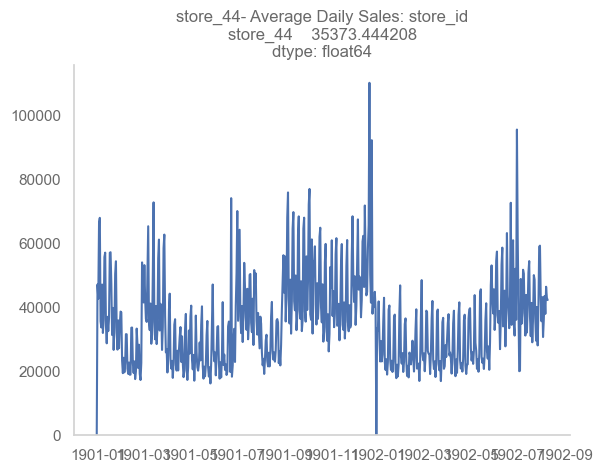

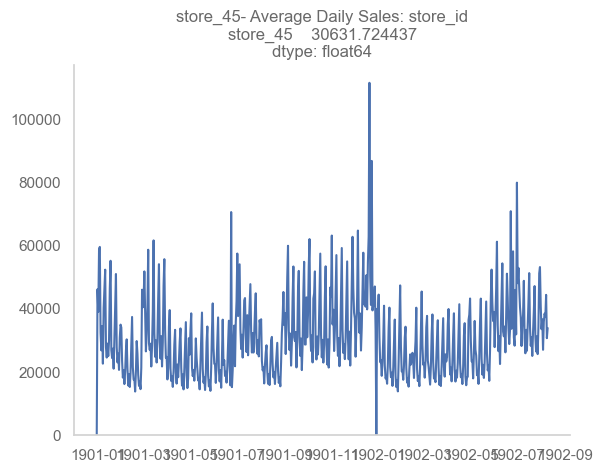

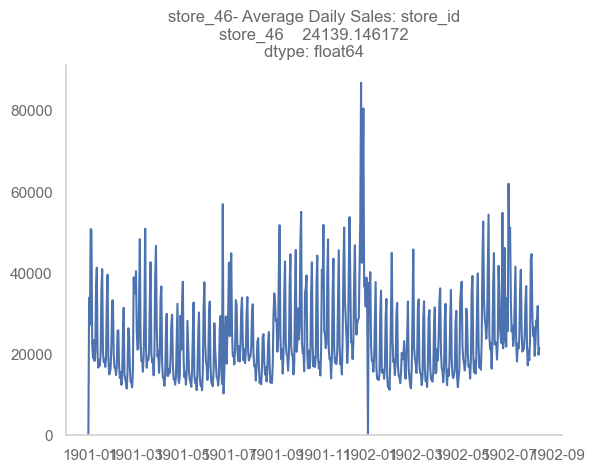

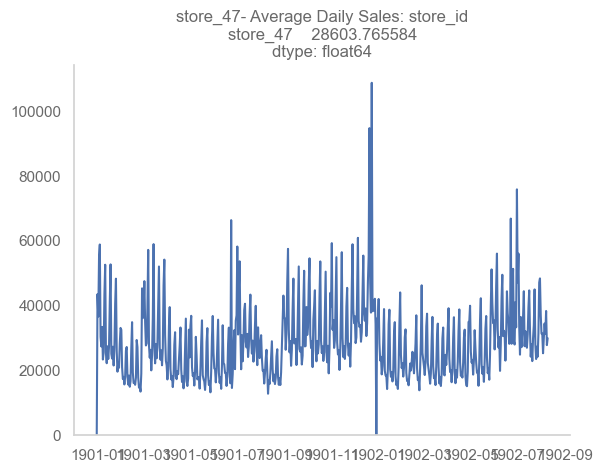

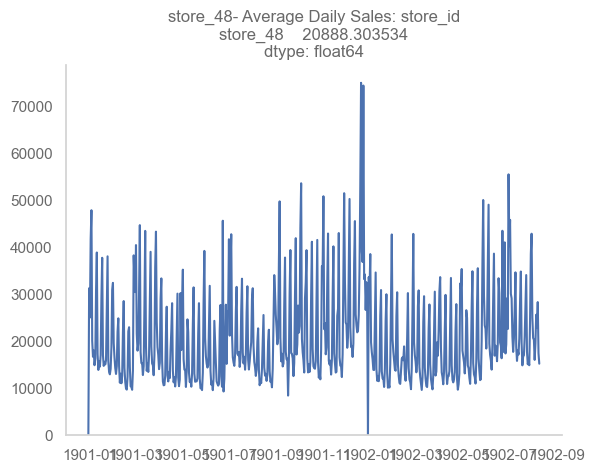

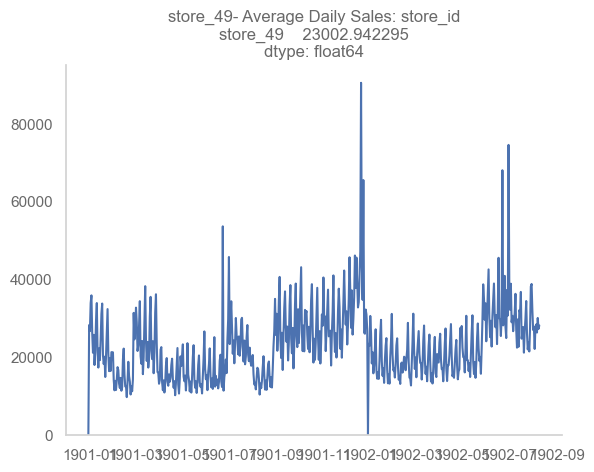

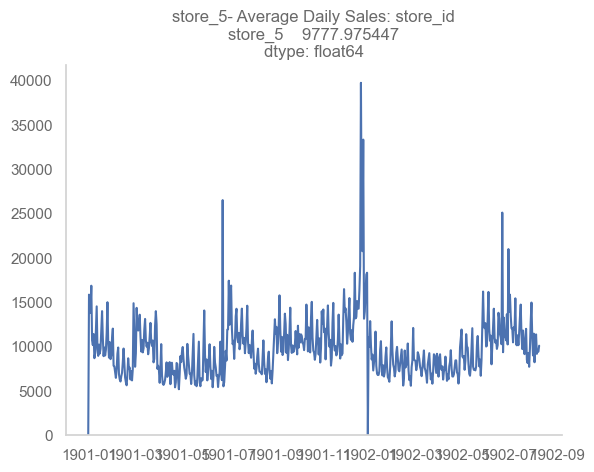

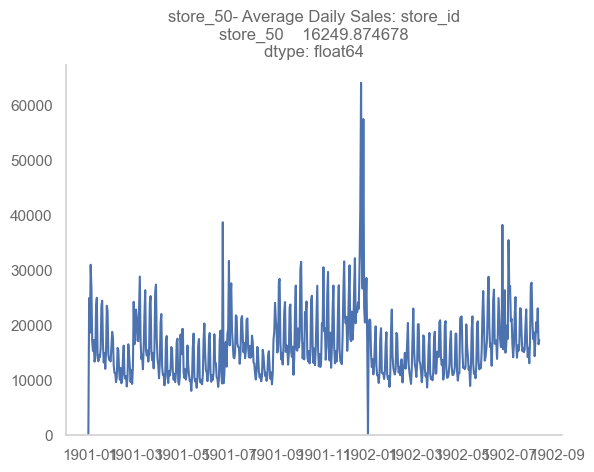

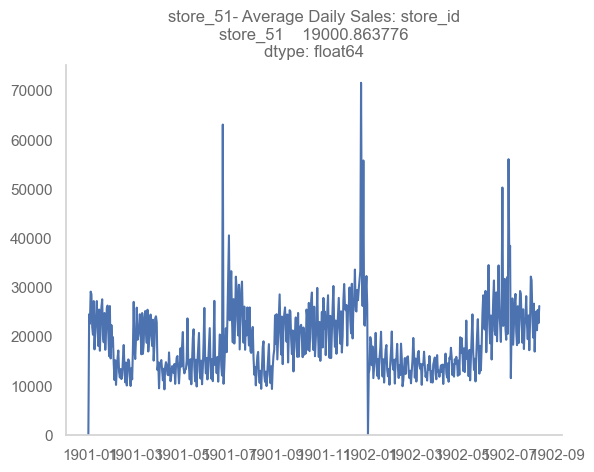

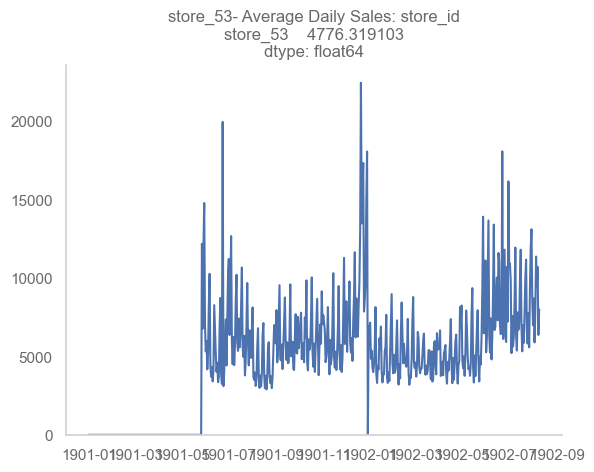

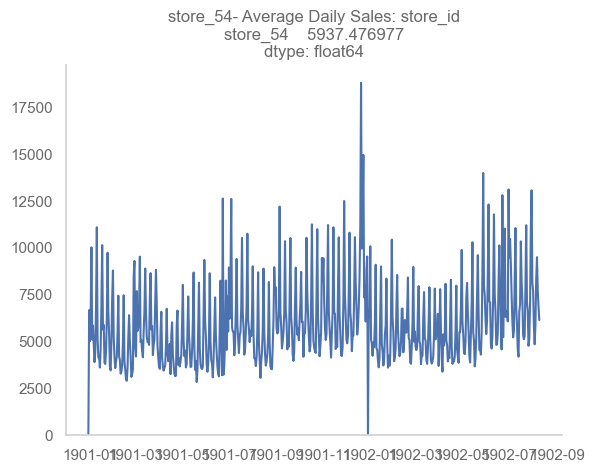

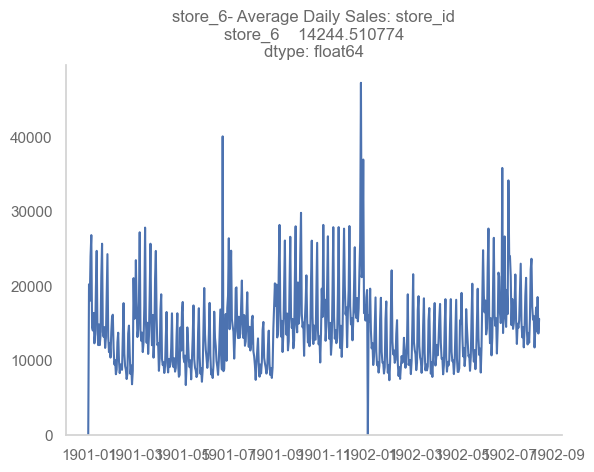

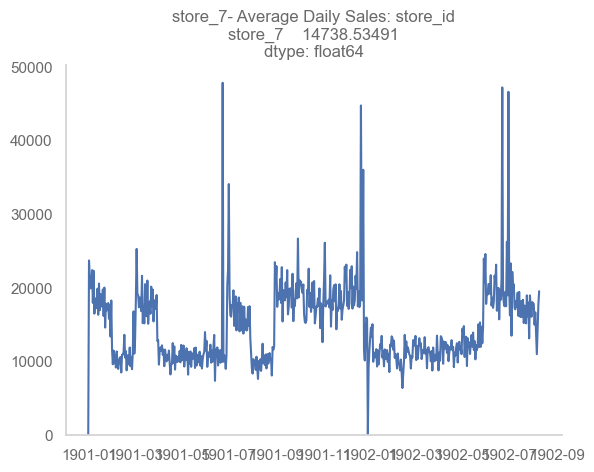

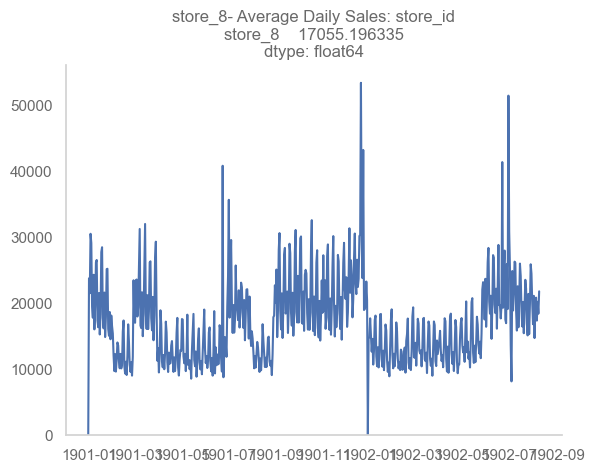

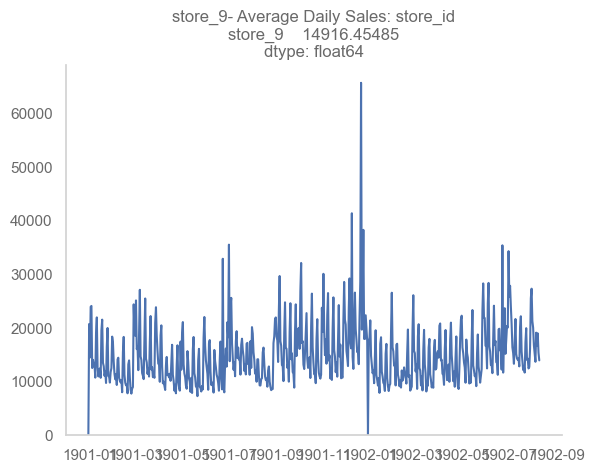

In [ ]:
for i in range(len(prediction_df_list)):
    # Plot the data in each DataFrame
    plt.plot(prediction_df_list[i])
    
    # Set the title of the plot
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    
    # Set the minimum y-axis limit to 0
    plt.ylim(ymin=0)
    
    # Display the plot
    plt.show()


This code snippet uses NumPy's linspace function to create a list of 5 numbers evenly spaced between 0.01 and 10, inclusive, and then converts it to a Python list. The resulting list will be [0.01, 2.5025, 5.015, 7.5275, 10.0]

In [ ]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()


In [ ]:
print(seasonality_prior_scale_range)

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]


This code performs hyperparameter tuning for a Prophet model using cross-validation to find the best set of parameters for each feature in total_sales_df. It iterates over each feature, creates a Prophet model for each combination of parameters in seasonality_prior_scale_range, evaluates the model using cross-validation, and selects the parameters that result in the lowest RMSE (Root Mean Squared Error). The best parameters for each feature are stored in the dicts dictionary.

In [ ]:
import time
import itertools
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
import pandas as pd
import numpy as np

# Define the range for seasonality_prior_scale
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

start_time = time.time() # Start timing the execution

dicts = {}  # Initialize an empty dictionary to store the best parameters for each feature


# Iterate over each feature in the total_sales_df DataFrame
for feature in total_sales_df.columns:

    # Create a new DataFrame for the current feature

    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"] # Rename columns to match Prophet's require

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])

    # Define the parameter grid for hyperparameter tuning

    param_grid = {  
        "seasonality_prior_scale": seasonality_prior_scale_range 
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    RMSE = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon="30 days")
        squared_errors = (df_cv['yhat'] - df_cv['y'])**2
        mean_squared_error = squared_errors.mean()
        rmse = np.sqrt(mean_squared_error)
        RMSE.append(rmse)  # Append RMSE to the list
        
        print("RMSE:", rmse)  # Print RMSE for each set of parameters

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["rmse"] = RMSE  # Assign RMSE values to the DataFrame
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))


15:40:48 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:40:49 - cmdstanpy - INFO - Chain [1] start processing
15:40:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.03it/s]15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:05,  1.71s/it]15:40:55 - cmdstanpy - INFO - Chain [1] start processing
15:40:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:03,  1.54s/it]15:40:56 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3965.873976094227


15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]15:41:01 - cmdstanpy - INFO - Chain [1] start processing
15:41:01 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]15:41:03 - cmdstanpy - INFO - Chain [1] start processing
15:41:04 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.25s/it]15:41:05 - cmdstanpy - INFO - Chain [1] start processing
15:41:05 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.25s/it]15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4069.1408954196754


15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:10 - cmdstanpy - INFO - Chain [1] start processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]15:41:11 - cmdstanpy - INFO - Chain [1] start processing
15:41:11 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]15:41:11 - cmdstanpy - INFO - Chain [1] start processing
15:41:12 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]15:41:12 - cmdstanpy - INFO - Chain [1] start processing
15:41:12 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.22it/s]15:41:13 - cmdstanpy - INFO - Chain [1] start processing
15:41:13 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4089.935566148213


15:41:16 - cmdstanpy - INFO - Chain [1] start processing
15:41:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:16 - cmdstanpy - INFO - Chain [1] start processing
15:41:17 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.17it/s]15:41:17 - cmdstanpy - INFO - Chain [1] start processing
15:41:17 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]15:41:18 - cmdstanpy - INFO - Chain [1] start processing
15:41:18 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.04it/s]15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.09s/it]15:41:21 - cmdstanpy - INFO - Chain [1] start processing
15:41:21 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.85s/it]15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4065.364736376656


15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:26 - cmdstanpy - INFO - Chain [1] start processing
15:41:27 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.29s/it]15:41:27 - cmdstanpy - INFO - Chain [1] start processing
15:41:28 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.04s/it]15:41:28 - cmdstanpy - INFO - Chain [1] start processing
15:41:28 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.22it/s]15:41:30 - cmdstanpy - INFO - Chain [1] start processing
15:41:30 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4067.345086318815
store_1
   seasonality_prior_scale         rmse
0                   0.0100  3965.873976
1                   2.5075  4069.140895
2                   5.0050  4089.935566
3                   7.5025  4065.364736
4                  10.0000  4067.345086


15:41:39 - cmdstanpy - INFO - Chain [1] start processing
15:41:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:40 - cmdstanpy - INFO - Chain [1] start processing
15:41:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:03<00:20,  3.47s/it]15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:05<00:14,  2.87s/it]15:41:46 - cmdstanpy - INFO - Chain [1] start processing
15:41:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:07<00:08,  2.15s/it]15:41:47 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:10<00:07,  2.46s/it]15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:50 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:11<00:03,  1.95s/it]15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1795.63095032677


15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:41:56 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.78s/it]15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.29s/it]15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:59 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.02it/s]15:41:59 - cmdstanpy - INFO - Chain [1] start processing
15:41:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.10it/s]15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1842.4567717585742


15:42:02 - cmdstanpy - INFO - Chain [1] start processing
15:42:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:02 - cmdstanpy - INFO - Chain [1] start processing
15:42:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]15:42:03 - cmdstanpy - INFO - Chain [1] start processing
15:42:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.39it/s]15:42:04 - cmdstanpy - INFO - Chain [1] start processing
15:42:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.12it/s]15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:07 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:03,  1.53s/it]15:42:08 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1845.9308833222733


15:42:10 - cmdstanpy - INFO - Chain [1] start processing
15:42:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:10 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.38it/s]15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.48it/s]15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.39it/s]15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.30it/s]15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1843.5302695409507


15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:27 - cmdstanpy - INFO - Chain [1] start processing
15:42:28 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:09,  1.62s/it]15:42:28 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.40s/it]15:42:30 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.34s/it]15:42:31 - cmdstanpy - INFO - Chain [1] start processing
15:42:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.10s/it]15:42:32 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.36s/it]15:42:33 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1841.422698255959
store_10
   seasonality_prior_scale         rmse
0                   0.0100  1795.630950
1                   2.5075  1842.456772
2                   5.0050  1845.930883
3                   7.5025  1843.530270
4                  10.0000  1841.422698


15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.45it/s]15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.55it/s]15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.45it/s]15:42:38 - cmdstanpy - INFO - Chain [1] start processing
15:42:38 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.41it/s]15:42:39 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4814.831817123894


15:42:40 - cmdstanpy - INFO - Chain [1] start processing
15:42:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:41 - cmdstanpy - INFO - Chain [1] start processing
15:42:41 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.58it/s]15:42:41 - cmdstanpy - INFO - Chain [1] start processing
15:42:41 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.56it/s]15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.33s/it]15:42:44 - cmdstanpy - INFO - Chain [1] start processing
15:42:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:05,  1.70s/it]15:42:47 - cmdstanpy - INFO - Chain [1] start processing
15:42:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.63s/it]15:42:48 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4896.420378508178


15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:57 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.68s/it]15:42:58 - cmdstanpy - INFO - Chain [1] start processing
15:42:58 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.33s/it]15:42:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.55s/it]15:43:00 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.29s/it]15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.24s/it]15:43:03 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4885.954293834643


15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.15s/it]15:43:08 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:11,  2.27s/it]15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:09<00:15,  3.79s/it]15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:12<00:09,  3.29s/it]15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:14<00:05,  2.75s/it]15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4885.039465066337


15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:43:26 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:07<00:43,  7.25s/it]15:43:33 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:08<00:18,  3.64s/it]15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:09<00:10,  2.58s/it]15:43:36 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:14<00:10,  3.53s/it]15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:19<00:08,  4.04s/it]15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4907.8066098802165
store_11
   seasonality_prior_scale         rmse
0                   0.0100  4814.831817
1                   2.5075  4896.420379
2                   5.0050  4885.954294
3                   7.5025  4885.039465
4                  10.0000  4907.806610


15:44:00 - cmdstanpy - INFO - Chain [1] start processing
15:44:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:44:02 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:14,  2.34s/it]15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:05 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.34s/it]15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.16s/it]15:44:07 - cmdstanpy - INFO - Chain [1] start processing
15:44:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.35s/it]15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.62s/it]15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4588.363752355234


15:44:13 - cmdstanpy - INFO - Chain [1] start processing
15:44:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:44:16 - cmdstanpy - INFO - Chain [1] start processing
15:44:17 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:03<00:19,  3.26s/it]15:44:18 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:05<00:12,  2.55s/it]15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:20 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:07,  1.80s/it]15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:10<00:07,  2.63s/it]15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:11<00:04,  2.33s/it]15:44:27 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4592.8027123298325


15:44:30 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:44:33 - cmdstanpy - INFO - Chain [1] start processing
15:44:33 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]15:44:34 - cmdstanpy - INFO - Chain [1] start processing
15:44:34 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.12it/s]15:44:34 - cmdstanpy - INFO - Chain [1] start processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.13it/s]15:44:35 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.29s/it]15:44:37 - cmdstanpy - INFO - Chain [1] start processing
15:44:37 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.35s/it]15:44:39 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4599.712779047891


15:44:42 - cmdstanpy - INFO - Chain [1] start processing
15:44:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:44:47 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:10<01:03, 10.63s/it]15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:11<00:25,  5.08s/it]15:44:57 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:15<00:18,  4.52s/it]15:45:00 - cmdstanpy - INFO - Chain [1] start processing
15:45:00 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:21<00:15,  5.15s/it]15:45:06 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:24<00:08,  4.45s/it]15:45:09 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4591.8865415311375


15:45:15 - cmdstanpy - INFO - Chain [1] start processing
15:45:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.12s/it]15:45:24 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.10s/it]15:45:25 - cmdstanpy - INFO - Chain [1] start processing
15:45:25 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.16s/it]15:45:27 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.62s/it]15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:30 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.58s/it]15:45:30 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4591.40871056649
store_12
   seasonality_prior_scale         rmse
0                   0.0100  4588.363752
1                   2.5075  4592.802712
2                   5.0050  4599.712779
3                   7.5025  4591.886542
4                  10.0000  4591.408711


15:45:32 - cmdstanpy - INFO - Chain [1] start processing
15:45:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:33 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.49s/it]15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:04,  1.01it/s]15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:36 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.31it/s]15:45:36 - cmdstanpy - INFO - Chain [1] start processing
15:45:36 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.24it/s]15:45:37 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2672.3717556740185


15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.50it/s]15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.57it/s]15:45:41 - cmdstanpy - INFO - Chain [1] start processing
15:45:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.49it/s]15:45:41 - cmdstanpy - INFO - Chain [1] start processing
15:45:41 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.52it/s]15:45:42 - cmdstanpy - INFO - Chain [1] start processing
15:45:42 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.55it/s]15:45:43 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2712.8593661354853


15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.34it/s]15:45:45 - cmdstanpy - INFO - Chain [1] start processing
15:45:45 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.44it/s]15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.56it/s]15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.58it/s]15:45:47 - cmdstanpy - INFO - Chain [1] start processing
15:45:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.54it/s]15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2720.896019185936


15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.41it/s]15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.38it/s]15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.47it/s]15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.47it/s]15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.49it/s]15:45:54 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2708.9326755721013


15:45:55 - cmdstanpy - INFO - Chain [1] start processing
15:45:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:45:56 - cmdstanpy - INFO - Chain [1] start processing
15:45:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.61it/s]15:45:56 - cmdstanpy - INFO - Chain [1] start processing
15:45:56 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.52it/s]15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.49it/s]15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.53it/s]15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.50it/s]15:45:59 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2707.1816868033334
store_13
   seasonality_prior_scale         rmse
0                   0.0100  2672.371756
1                   2.5075  2712.859366
2                   5.0050  2720.896019
3                   7.5025  2708.932676
4                  10.0000  2707.181687


15:46:00 - cmdstanpy - INFO - Chain [1] start processing
15:46:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:01 - cmdstanpy - INFO - Chain [1] start processing
15:46:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.54it/s]15:46:02 - cmdstanpy - INFO - Chain [1] start processing
15:46:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.59it/s]15:46:02 - cmdstanpy - INFO - Chain [1] start processing
15:46:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.60it/s]15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.60it/s]15:46:04 - cmdstanpy - INFO - Chain [1] start processing
15:46:04 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.57it/s]15:46:04 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2513.577879702625


15:46:06 - cmdstanpy - INFO - Chain [1] start processing
15:46:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:06 - cmdstanpy - INFO - Chain [1] start processing
15:46:06 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.69it/s]15:46:07 - cmdstanpy - INFO - Chain [1] start processing
15:46:07 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.63it/s]15:46:08 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.60it/s]15:46:08 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.56it/s]15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.57it/s]15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2650.935010751223


15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.70it/s]15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.67it/s]15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.66it/s]15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.63it/s]15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.59it/s]15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2653.7253437842883


15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.72it/s]15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.65it/s]15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.61it/s]15:46:19 - cmdstanpy - INFO - Chain [1] start processing
15:46:19 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.59it/s]15:46:19 - cmdstanpy - INFO - Chain [1] start processing
15:46:19 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.55it/s]15:46:20 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2652.926246677377


15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.68it/s]15:46:23 - cmdstanpy - INFO - Chain [1] start processing
15:46:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.63it/s]15:46:23 - cmdstanpy - INFO - Chain [1] start processing
15:46:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.60it/s]15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:26 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:06,  2.24s/it]15:46:29 - cmdstanpy - INFO - Chain [1] start processing
15:46:30 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:04,  2.13s/it]15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2647.941676087249
store_14
   seasonality_prior_scale         rmse
0                   0.0100  2513.577880
1                   2.5075  2650.935011
2                   5.0050  2653.725344
3                   7.5025  2652.926247
4                  10.0000  2647.941676


15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.61it/s]15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.66it/s]15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.72it/s]15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.69it/s]15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.63it/s]15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 1991.2596155178103


15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.64it/s]15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.69it/s]15:46:39 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.67it/s]15:46:39 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.65it/s]15:46:40 - cmdstanpy - INFO - Chain [1] start processing
15:46:40 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.50it/s]15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2011.0848327686751


15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.48it/s]15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.55it/s]15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.48it/s]15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.51it/s]15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.43it/s]15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2013.7956675999176


15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.56it/s]15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.61it/s]15:46:51 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.57it/s]15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.62it/s]15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.61it/s]15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2003.3183499186846


15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:46:55 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.63it/s]15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.67it/s]15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.63it/s]15:46:57 - cmdstanpy - INFO - Chain [1] start processing
15:46:57 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.62it/s]15:46:57 - cmdstanpy - INFO - Chain [1] start processing
15:46:57 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.61it/s]15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2001.8074721209623
store_15
   seasonality_prior_scale         rmse
0                   0.0100  1991.259616
1                   2.5075  2011.084833
2                   5.0050  2013.795668
3                   7.5025  2003.318350
4                  10.0000  2001.807472


15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.44it/s]15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.56it/s]15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.54it/s]15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.57it/s]15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:03 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.25s/it]15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2942.469933505522


15:47:10 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:12 - cmdstanpy - INFO - Chain [1] start processing
15:47:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]15:47:13 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.53s/it]15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:17 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:10,  2.64s/it]15:47:18 - cmdstanpy - INFO - Chain [1] start processing
15:47:20 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:11<00:10,  3.59s/it]15:47:24 - cmdstanpy - INFO - Chain [1] start processing
15:47:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:14<00:06,  3.16s/it]15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3026.4135427998103


15:47:28 - cmdstanpy - INFO - Chain [1] start processing
15:47:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:29 - cmdstanpy - INFO - Chain [1] start processing
15:47:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.68it/s]15:47:29 - cmdstanpy - INFO - Chain [1] start processing
15:47:29 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.55it/s]15:47:30 - cmdstanpy - INFO - Chain [1] start processing
15:47:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.37it/s]15:47:31 - cmdstanpy - INFO - Chain [1] start processing
15:47:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.42it/s]15:47:31 - cmdstanpy - INFO - Chain [1] start processing
15:47:32 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.46it/s]15:47:32 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3006.409512905246


15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.76it/s]15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.63it/s]15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.63it/s]15:47:36 - cmdstanpy - INFO - Chain [1] start processing
15:47:36 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.57it/s]15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.58it/s]15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3015.4982107116703


15:47:39 - cmdstanpy - INFO - Chain [1] start processing
15:47:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:39 - cmdstanpy - INFO - Chain [1] start processing
15:47:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.49it/s]15:47:40 - cmdstanpy - INFO - Chain [1] start processing
15:47:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.05it/s]15:47:41 - cmdstanpy - INFO - Chain [1] start processing
15:47:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.39s/it]15:47:43 - cmdstanpy - INFO - Chain [1] start processing
15:47:44 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.30s/it]15:47:44 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.67s/it]15:47:47 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3050.38813352198
store_16
   seasonality_prior_scale         rmse
0                   0.0100  2942.469934
1                   2.5075  3026.413543
2                   5.0050  3006.409513
3                   7.5025  3015.498211
4                  10.0000  3050.388134


15:47:49 - cmdstanpy - INFO - Chain [1] start processing
15:47:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:50 - cmdstanpy - INFO - Chain [1] start processing
15:47:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.31s/it]15:47:51 - cmdstanpy - INFO - Chain [1] start processing
15:47:51 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.31s/it]15:47:52 - cmdstanpy - INFO - Chain [1] start processing
15:47:52 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.06s/it]15:47:53 - cmdstanpy - INFO - Chain [1] start processing
15:47:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.37s/it]15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.47s/it]15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3292.802945867852


15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.48it/s]15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:05,  1.05s/it]15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.12it/s]15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.17it/s]15:48:02 - cmdstanpy - INFO - Chain [1] start processing
15:48:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.22it/s]15:48:03 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3349.9150466782867


15:48:04 - cmdstanpy - INFO - Chain [1] start processing
15:48:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.44it/s]15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:06 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.49it/s]15:48:06 - cmdstanpy - INFO - Chain [1] start processing
15:48:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.57it/s]15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.58it/s]15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:07 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.55it/s]15:48:08 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3336.9677643546065



15:48:10 - cmdstanpy - INFO - Chain [1] start processing
15:48:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:10 - cmdstanpy - INFO - Chain [1] start processing
15:48:10 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.55it/s]15:48:11 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.62it/s]15:48:11 - cmdstanpy - INFO - Chain [1] start processing
15:48:12 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.62it/s]15:48:12 - cmdstanpy - INFO - Chain [1] start processing
15:48:12 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.58it/s]15:48:13 - cmdstanpy - INFO - Chain [1] start processing
15:48:13 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.55it/s]15:48:13 - cmdstanpy - INFO - Chain [1] start processing
15

RMSE: 3350.950251613716


15:48:15 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:16 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.56it/s]15:48:16 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.04it/s]15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.02it/s]15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.64s/it]15:48:21 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.32s/it]15:48:22 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3348.1771493061915
store_17
   seasonality_prior_scale         rmse
0                   0.0100  3292.802946
1                   2.5075  3349.915047
2                   5.0050  3336.967764
3                   7.5025  3350.950252
4                  10.0000  3348.177149


15:48:24 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:25 - cmdstanpy - INFO - Chain [1] start processing
15:48:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.24s/it]15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.19s/it]15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:27 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.19s/it]15:48:28 - cmdstanpy - INFO - Chain [1] start processing
15:48:28 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.01s/it]15:48:29 - cmdstanpy - INFO - Chain [1] start processing
15:48:29 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]15:48:30 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3170.990480006349


15:48:31 - cmdstanpy - INFO - Chain [1] start processing
15:48:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:31 - cmdstanpy - INFO - Chain [1] start processing
15:48:32 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.61it/s]15:48:32 - cmdstanpy - INFO - Chain [1] start processing
15:48:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.64it/s]15:48:33 - cmdstanpy - INFO - Chain [1] start processing
15:48:33 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.66it/s]15:48:33 - cmdstanpy - INFO - Chain [1] start processing
15:48:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.69it/s]15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:01,  1.68it/s]15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3247.7901445857565


15:48:36 - cmdstanpy - INFO - Chain [1] start processing
15:48:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:38 - cmdstanpy - INFO - Chain [1] start processing
15:48:43 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:06<00:38,  6.34s/it]15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:07<00:15,  3.17s/it]15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:08<00:08,  2.14s/it]15:48:45 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:04,  1.60s/it]15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:10<00:02,  1.40s/it]15:48:47 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3254.0344295875107


15:48:49 - cmdstanpy - INFO - Chain [1] start processing
15:48:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.49it/s]15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.55it/s]15:48:51 - cmdstanpy - INFO - Chain [1] start processing
15:48:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.56it/s]15:48:51 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.47it/s]15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.41it/s]15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3250.385638417166


15:48:55 - cmdstanpy - INFO - Chain [1] start processing
15:48:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:48:56 - cmdstanpy - INFO - Chain [1] start processing
15:48:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:48:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.45it/s]15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:48:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.54it/s]15:48:58 - cmdstanpy - INFO - Chain [1] start processing
15:48:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.57it/s]15:48:58 - cmdstanpy - INFO - Chain [1] start processing
15:48:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.57it/s]15:48:59 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3245.972635678057
store_18
   seasonality_prior_scale         rmse
0                   0.0100  3170.990480
1                   2.5075  3247.790145
2                   5.0050  3254.034430
3                   7.5025  3250.385638
4                  10.0000  3245.972636


15:49:01 - cmdstanpy - INFO - Chain [1] start processing
15:49:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:49:02 - cmdstanpy - INFO - Chain [1] start processing
15:49:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:38<03:50, 38.41s/it]15:49:40 - cmdstanpy - INFO - Chain [1] start processing
15:49:46 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:45<01:40, 20.05s/it]15:49:48 - cmdstanpy - INFO - Chain [1] start processing
15:49:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:48<00:49, 12.41s/it]15:49:52 - cmdstanpy - INFO - Chain [1] start processing
15:49:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:52<00:26,  8.86s/it]15:49:54 - cmdstanpy - INFO - Chain [1] start processing
15:49:54 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:53<00:12,  6.14s/it]15:49:55 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2637.8067152131916


15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:58 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]15:49:58 - cmdstanpy - INFO - Chain [1] start processing
15:49:59 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.53s/it]15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:09,  2.41s/it]15:50:05 - cmdstanpy - INFO - Chain [1] start processing
15:50:13 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:16<00:16,  5.43s/it]15:50:14 - cmdstanpy - INFO - Chain [1] start processing
15:50:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:17<00:08,  4.04s/it]15:50:15 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2739.2842257773823


15:50:17 - cmdstanpy - INFO - Chain [1] start processing
15:50:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:50:19 - cmdstanpy - INFO - Chain [1] start processing
15:50:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:15,  2.64s/it]15:50:22 - cmdstanpy - INFO - Chain [1] start processing
15:50:22 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.65s/it]15:50:23 - cmdstanpy - INFO - Chain [1] start processing
15:50:25 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:09,  2.26s/it]15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:06,  2.06s/it]15:50:28 - cmdstanpy - INFO - Chain [1] start processing
15:50:29 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:12<00:05,  2.69s/it]15:50:32 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2741.669302643055


15:50:36 - cmdstanpy - INFO - Chain [1] start processing
15:50:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]15:50:38 - cmdstanpy - INFO - Chain [1] start processing
15:50:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:07<00:21,  4.26s/it]15:50:44 - cmdstanpy - INFO - Chain [1] start processing
15:50:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:08<00:10,  2.72s/it]15:50:45 - cmdstanpy - INFO - Chain [1] start processing
15:50:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:09<00:06,  2.16s/it]15:50:47 - cmdstanpy - INFO - Chain [1] start processing
15:50:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:10<00:03,  1.85s/it]15:50:48 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2739.4759510353797


15:50:50 - cmdstanpy - INFO - Chain [1] start processing
15:50:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:50:51 - cmdstanpy - INFO - Chain [1] start processing
15:50:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.14it/s]15:50:51 - cmdstanpy - INFO - Chain [1] start processing
15:50:52 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]15:50:52 - cmdstanpy - INFO - Chain [1] start processing
15:50:53 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:08<00:13,  3.36s/it]15:50:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:21<00:21,  7.28s/it]15:51:15 - cmdstanpy - INFO - Chain [1] start processing
15:51:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:25<00:12,  6.13s/it]15:51:16 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2746.3696938206817
store_19
   seasonality_prior_scale         rmse
0                   0.0100  2637.806715
1                   2.5075  2739.284226
2                   5.0050  2741.669303
3                   7.5025  2739.475951
4                  10.0000  2746.369694


15:51:20 - cmdstanpy - INFO - Chain [1] start processing
15:51:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:51:21 - cmdstanpy - INFO - Chain [1] start processing
15:51:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.37s/it]15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:09,  1.86s/it]15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:08,  2.02s/it]15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:06,  2.05s/it]15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:10<00:04,  2.39s/it]15:51:32 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4799.908240083541


15:51:38 - cmdstanpy - INFO - Chain [1] start processing
15:51:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:51:39 - cmdstanpy - INFO - Chain [1] start processing
15:51:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.26s/it]15:51:41 - cmdstanpy - INFO - Chain [1] start processing
15:51:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:17,  3.49s/it]15:51:45 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:07<00:10,  2.57s/it]15:51:47 - cmdstanpy - INFO - Chain [1] start processing
15:51:48 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:10<00:07,  2.51s/it]15:51:49 - cmdstanpy - INFO - Chain [1] start processing
15:51:49 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:11<00:04,  2.10s/it]15:51:51 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4861.335394201871


15:51:56 - cmdstanpy - INFO - Chain [1] start processing
15:51:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:51:58 - cmdstanpy - INFO - Chain [1] start processing
15:51:58 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.71s/it]15:51:59 - cmdstanpy - INFO - Chain [1] start processing
15:51:59 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.36s/it]15:52:01 - cmdstanpy - INFO - Chain [1] start processing
15:52:01 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.40s/it]15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.16s/it]15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.03it/s]15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4900.494187038839


15:52:04 - cmdstanpy - INFO - Chain [1] start processing
15:52:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:52:05 - cmdstanpy - INFO - Chain [1] start processing
15:52:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.56it/s]15:52:05 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.58it/s]15:52:06 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.53it/s]15:52:07 - cmdstanpy - INFO - Chain [1] start processing
15:52:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.56it/s]15:52:07 - cmdstanpy - INFO - Chain [1] start processing
15:52:07 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.53it/s]15:52:08 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4852.852273907665


15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:15,  2.50s/it]15:52:30 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:17,  3.54s/it]15:52:34 - cmdstanpy - INFO - Chain [1] start processing
15:52:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:08<00:10,  2.66s/it]15:52:35 - cmdstanpy - INFO - Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:09<00:06,  2.02s/it]15:52:36 - cmdstanpy - INFO - Chain [1] start processing
15:52:37 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:10<00:03,  1.59s/it]15:52:37 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4851.351171597404
store_2
   seasonality_prior_scale         rmse
0                   0.0100  4799.908240
1                   2.5075  4861.335394
2                   5.0050  4900.494187
3                   7.5025  4852.852274
4                  10.0000  4851.351172


15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:02,  2.08it/s]15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.50it/s]15:52:41 - cmdstanpy - INFO - Chain [1] start processing
15:52:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]15:52:42 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.23it/s]15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:43 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]15:52:44 - cmdstanpy - INFO - Chain [1] start processing
15:52:44 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:05<00:00,  1.12it/s]15:52:45 - cmdstanpy - INFO - Chain [1] start proces

RMSE: 6312.732102198685


15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.85it/s]15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.40it/s]15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.34s/it]15:53:11 - cmdstanpy - INFO - Chain [1] start processing
15:53:12 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:08,  2.81s/it]15:53:15 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:14<00:07,  3.77s/it]15:53:21 - cmdstanpy - INFO - Chain [1] start processing
15:53:21 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:15<00:02,  2.94s/it]15:53:22 - cmdstanpy - INFO - Chain [1] start proces

RMSE: 6254.1001531725105


15:53:24 - cmdstanpy - INFO - Chain [1] start processing
15:53:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.72it/s]15:53:26 - cmdstanpy - INFO - Chain [1] start processing
15:53:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]15:53:28 - cmdstanpy - INFO - Chain [1] start processing
15:53:28 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.27s/it]15:53:29 - cmdstanpy - INFO - Chain [1] start processing
15:53:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.14s/it]15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:30 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.13s/it]15:53:31 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:06<00:01,  1.03s/it]15:53:32 - cmdstanpy - INFO - Chain [1] start proces

RMSE: 6227.400533780857


15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:02,  2.08it/s]15:53:34 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.52it/s]15:53:35 - cmdstanpy - INFO - Chain [1] start processing
15:53:35 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.35it/s]15:53:36 - cmdstanpy - INFO - Chain [1] start processing
15:53:36 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.25it/s]15:53:37 - cmdstanpy - INFO - Chain [1] start processing
15:53:37 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.21it/s]15:53:37 - cmdstanpy - INFO - Chain [1] start processing
15:53:38 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:04<00:00,  1.20it/s]15:53:38 - cmdstanpy - INFO - Chain [1] start proces

RMSE: 6198.531646601653


15:53:39 - cmdstanpy - INFO - Chain [1] start processing
15:53:40 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:09,  1.96s/it]15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.41s/it]15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.45s/it]15:53:47 - cmdstanpy - INFO - Chain [1] start processing
15:53:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:18<00:11,  5.62s/it]15:54:00 - cmdstanpy - INFO - Chain [1] start processing
15:54:00 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:20<00:04,  4.26s/it]15:54:01 - cmdstanpy - INFO - Chain [1] start proces

RMSE: 6223.3777913025215
store_20
   seasonality_prior_scale         rmse
0                   0.0100  6312.732102
1                   2.5075  6254.100153
2                   5.0050  6227.400534
3                   7.5025  6198.531647
4                  10.0000  6223.377791


15:54:02 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:54:08 - cmdstanpy - INFO - Chain [1] start processing
15:54:10 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:15,  2.54s/it]15:54:10 - cmdstanpy - INFO - Chain [1] start processing
15:54:11 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:12<00:33,  6.69s/it]15:54:20 - cmdstanpy - INFO - Chain [1] start processing
15:54:21 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:13<00:16,  4.16s/it]15:54:21 - cmdstanpy - INFO - Chain [1] start processing
15:54:21 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:14<00:08,  2.85s/it]15:54:22 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:15<00:04,  2.22s/it]15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2149.7688641801183


15:54:27 - cmdstanpy - INFO - Chain [1] start processing
15:54:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:54:29 - cmdstanpy - INFO - Chain [1] start processing
15:54:30 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:14,  2.43s/it]15:54:31 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:10,  2.12s/it]15:54:33 - cmdstanpy - INFO - Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:08,  2.03s/it]15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:04,  1.56s/it]15:54:35 - cmdstanpy - INFO - Chain [1] start processing
15:54:35 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:02,  1.34s/it]15:54:36 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2152.325237217465


15:54:38 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:54:39 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.29it/s]15:54:40 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]15:54:41 - cmdstanpy - INFO - Chain [1] start processing
15:54:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.13it/s]15:54:42 - cmdstanpy - INFO - Chain [1] start processing
15:54:42 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.05it/s]15:54:43 - cmdstanpy - INFO - Chain [1] start processing
15:54:43 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.00s/it]15:54:44 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2148.9674998292357


15:54:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:30 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:08<00:52,  8.77s/it]15:55:33 - cmdstanpy - INFO - Chain [1] start processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:12<00:29,  5.84s/it]15:55:37 - cmdstanpy - INFO - Chain [1] start processing
15:55:38 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:16<00:19,  4.97s/it]15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:25<00:19,  6.66s/it]15:55:54 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:36<00:16,  8.25s/it]15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2156.011194674181


15:56:18 - cmdstanpy - INFO - Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:56:22 - cmdstanpy - INFO - Chain [1] start processing
15:56:23 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:04<00:29,  4.90s/it]15:56:26 - cmdstanpy - INFO - Chain [1] start processing
15:56:27 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:08<00:20,  4.10s/it]15:56:30 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:12<00:16,  4.20s/it]15:56:34 - cmdstanpy - INFO - Chain [1] start processing
15:56:35 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:17<00:12,  4.28s/it]15:56:39 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:23<00:09,  4.93s/it]15:56:49 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2155.7555672626904
store_23
   seasonality_prior_scale         rmse
0                   0.0100  2149.768864
1                   2.5075  2152.325237
2                   5.0050  2148.967500
3                   7.5025  2156.011195
4                  10.0000  2155.755567


15:56:59 - cmdstanpy - INFO - Chain [1] start processing
15:56:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:57:01 - cmdstanpy - INFO - Chain [1] start processing
15:57:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:03<00:18,  3.05s/it]15:57:04 - cmdstanpy - INFO - Chain [1] start processing
15:57:05 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:15,  3.11s/it]15:57:14 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:17<00:26,  6.72s/it]15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:19<00:14,  4.79s/it]15:57:21 - cmdstanpy - INFO - Chain [1] start processing
15:57:22 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:23<00:09,  4.60s/it]15:57:25 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 6123.856407916949


15:57:32 - cmdstanpy - INFO - Chain [1] start processing
15:57:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:57:34 - cmdstanpy - INFO - Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:14,  2.36s/it]15:57:36 - cmdstanpy - INFO - Chain [1] start processing
15:57:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.72s/it]15:57:38 - cmdstanpy - INFO - Chain [1] start processing
15:57:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:08,  2.12s/it]15:57:40 - cmdstanpy - INFO - Chain [1] start processing
15:57:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.88s/it]15:57:41 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:09<00:03,  1.73s/it]15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 6218.464504166239


15:57:45 - cmdstanpy - INFO - Chain [1] start processing
15:57:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:57:46 - cmdstanpy - INFO - Chain [1] start processing
15:57:46 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]15:57:47 - cmdstanpy - INFO - Chain [1] start processing
15:57:47 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.06it/s]15:57:48 - cmdstanpy - INFO - Chain [1] start processing
15:57:48 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.04it/s]15:57:49 - cmdstanpy - INFO - Chain [1] start processing
15:57:49 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.07it/s]15:57:50 - cmdstanpy - INFO - Chain [1] start processing
15:57:50 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.00it/s]15:57:51 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 6127.617305841902


15:57:53 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:57:54 - cmdstanpy - INFO - Chain [1] start processing
15:57:54 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.20it/s]15:57:55 - cmdstanpy - INFO - Chain [1] start processing
15:57:55 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.31it/s]15:57:55 - cmdstanpy - INFO - Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]15:57:57 - cmdstanpy - INFO - Chain [1] start processing
15:57:57 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.03s/it]15:57:58 - cmdstanpy - INFO - Chain [1] start processing
15:57:58 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.06s/it]15:57:59 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 6131.559994275239


15:58:01 - cmdstanpy - INFO - Chain [1] start processing
15:58:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:03 - cmdstanpy - INFO - Chain [1] start processing
15:58:03 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.19s/it]15:58:04 - cmdstanpy - INFO - Chain [1] start processing
15:58:04 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.08s/it]15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.29it/s]15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.26it/s]15:58:07 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 6147.425931401075
store_24
   seasonality_prior_scale         rmse
0                   0.0100  6123.856408
1                   2.5075  6218.464504
2                   5.0050  6127.617306
3                   7.5025  6131.559994
4                  10.0000  6147.425931


15:58:08 - cmdstanpy - INFO - Chain [1] start processing
15:58:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.85it/s]15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.82it/s]15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.92it/s]15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:10 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.95it/s]15:58:11 - cmdstanpy - INFO - Chain [1] start processing
15:58:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.03s/it]15:58:13 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3823.4845055865267


15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:15 - cmdstanpy - INFO - Chain [1] start processing
15:58:15 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.41it/s]15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.55it/s]15:58:16 - cmdstanpy - INFO - Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.44it/s]15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.37it/s]15:58:18 - cmdstanpy - INFO - Chain [1] start processing
15:58:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.39it/s]15:58:19 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3839.734571056912


15:58:20 - cmdstanpy - INFO - Chain [1] start processing
15:58:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:20 - cmdstanpy - INFO - Chain [1] start processing
15:58:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.58it/s]15:58:21 - cmdstanpy - INFO - Chain [1] start processing
15:58:21 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.74it/s]15:58:22 - cmdstanpy - INFO - Chain [1] start processing
15:58:22 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.82it/s]15:58:22 - cmdstanpy - INFO - Chain [1] start processing
15:58:22 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.92it/s]15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.52it/s]15:58:24 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3843.312379391252


15:58:25 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:25 - cmdstanpy - INFO - Chain [1] start processing
15:58:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.57it/s]15:58:26 - cmdstanpy - INFO - Chain [1] start processing
15:58:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:02,  1.71it/s]15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.68it/s]15:58:27 - cmdstanpy - INFO - Chain [1] start processing
15:58:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.73it/s]15:58:28 - cmdstanpy - INFO - Chain [1] start processing
15:58:28 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:01,  1.73it/s]15:58:29 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3844.9527441034083


15:58:30 - cmdstanpy - INFO - Chain [1] start processing
15:58:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:31 - cmdstanpy - INFO - Chain [1] start processing
15:58:31 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.69it/s]15:58:31 - cmdstanpy - INFO - Chain [1] start processing
15:58:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.37it/s]15:58:32 - cmdstanpy - INFO - Chain [1] start processing
15:58:33 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]15:58:33 - cmdstanpy - INFO - Chain [1] start processing
15:58:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.26it/s]15:58:34 - cmdstanpy - INFO - Chain [1] start processing
15:58:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 3834.881438401007
store_25
   seasonality_prior_scale         rmse
0                   0.0100  3823.484506
1                   2.5075  3839.734571
2                   5.0050  3843.312379
3                   7.5025  3844.952744
4                  10.0000  3834.881438


15:58:38 - cmdstanpy - INFO - Chain [1] start processing
15:58:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:39 - cmdstanpy - INFO - Chain [1] start processing
15:58:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]15:58:40 - cmdstanpy - INFO - Chain [1] start processing
15:58:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]15:58:41 - cmdstanpy - INFO - Chain [1] start processing
15:58:42 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.30s/it]15:58:42 - cmdstanpy - INFO - Chain [1] start processing
15:58:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.15s/it]15:58:43 - cmdstanpy - INFO - Chain [1] start processing
15:58:44 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.07s/it]15:58:44 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2795.4166173875115


15:58:46 - cmdstanpy - INFO - Chain [1] start processing
15:58:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:48 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:11,  1.91s/it]15:58:49 - cmdstanpy - INFO - Chain [1] start processing
15:58:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:10,  2.06s/it]15:58:52 - cmdstanpy - INFO - Chain [1] start processing
15:58:52 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:09,  2.32s/it]15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.70s/it]15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:02,  1.49s/it]15:58:56 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2844.126247753896


15:58:57 - cmdstanpy - INFO - Chain [1] start processing
15:58:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]15:59:00 - cmdstanpy - INFO - Chain [1] start processing
15:59:00 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]15:59:01 - cmdstanpy - INFO - Chain [1] start processing
15:59:01 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:04,  1.03s/it]15:59:02 - cmdstanpy - INFO - Chain [1] start processing
15:59:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.21s/it]15:59:03 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.26s/it]15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2823.143240909678


15:59:12 - cmdstanpy - INFO - Chain [1] start processing
15:59:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:13 - cmdstanpy - INFO - Chain [1] start processing
15:59:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.10s/it]15:59:15 - cmdstanpy - INFO - Chain [1] start processing
15:59:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.76s/it]15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.64s/it]15:59:18 - cmdstanpy - INFO - Chain [1] start processing
15:59:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.37s/it]15:59:19 - cmdstanpy - INFO - Chain [1] start processing
15:59:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.78s/it]15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2842.7470746895665


15:59:24 - cmdstanpy - INFO - Chain [1] start processing
15:59:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:25 - cmdstanpy - INFO - Chain [1] start processing
15:59:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]15:59:26 - cmdstanpy - INFO - Chain [1] start processing
15:59:27 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.43s/it]15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.29s/it]15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.22s/it]15:59:30 - cmdstanpy - INFO - Chain [1] start processing
15:59:30 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 2845.6411542526093
store_26
   seasonality_prior_scale         rmse
0                   0.0100  2795.416617
1                   2.5075  2844.126248
2                   5.0050  2823.143241
3                   7.5025  2842.747075
4                  10.0000  2845.641154


15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]15:59:36 - cmdstanpy - INFO - Chain [1] start processing
15:59:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]15:59:37 - cmdstanpy - INFO - Chain [1] start processing
15:59:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.32it/s]15:59:38 - cmdstanpy - INFO - Chain [1] start processing
15:59:38 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.25it/s]15:59:38 - cmdstanpy - INFO - Chain [1] start processing
15:59:38 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]15:59:39 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4395.532537721699


15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.35s/it]15:59:43 - cmdstanpy - INFO - Chain [1] start processing
15:59:43 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:04,  1.01it/s]15:59:44 - cmdstanpy - INFO - Chain [1] start processing
15:59:44 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]15:59:44 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.34it/s]15:59:45 - cmdstanpy - INFO - Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.32it/s]15:59:46 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4518.413879691236


15:59:47 - cmdstanpy - INFO - Chain [1] start processing
15:59:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:48 - cmdstanpy - INFO - Chain [1] start processing
15:59:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.60it/s]15:59:49 - cmdstanpy - INFO - Chain [1] start processing
15:59:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.56it/s]15:59:49 - cmdstanpy - INFO - Chain [1] start processing
15:59:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]15:59:50 - cmdstanpy - INFO - Chain [1] start processing
15:59:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.25it/s]15:59:51 - cmdstanpy - INFO - Chain [1] start processing
15:59:51 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]15:59:52 - cmdstanpy - INFO - Chain [1] start processing
15:

RMSE: 4497.6183677193485


15:59:55 - cmdstanpy - INFO - Chain [1] start processing
15:59:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]15:59:55 - cmdstanpy - INFO - Chain [1] start processing
15:59:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]15:59:56 - cmdstanpy - INFO - Chain [1] start processing
15:59:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.10it/s]15:59:57 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]15:59:58 - cmdstanpy - INFO - Chain [1] start processing
15:59:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.23it/s]15:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.28it/s]16:00:00 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4538.504675699553


16:00:01 - cmdstanpy - INFO - Chain [1] start processing
16:00:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:00:02 - cmdstanpy - INFO - Chain [1] start processing
16:00:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.46it/s]16:00:03 - cmdstanpy - INFO - Chain [1] start processing
16:00:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.43it/s]16:00:04 - cmdstanpy - INFO - Chain [1] start processing
16:00:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.38it/s]16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.38it/s]16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:06 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]16:00:06 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4521.519692260575
store_27
   seasonality_prior_scale         rmse
0                   0.0100  4395.532538
1                   2.5075  4518.413880
2                   5.0050  4497.618368
3                   7.5025  4538.504676
4                  10.0000  4521.519692


16:00:08 - cmdstanpy - INFO - Chain [1] start processing
16:00:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:00:08 - cmdstanpy - INFO - Chain [1] start processing
16:00:08 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]16:00:09 - cmdstanpy - INFO - Chain [1] start processing
16:00:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]16:00:10 - cmdstanpy - INFO - Chain [1] start processing
16:00:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.34it/s]16:00:10 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.39it/s]16:00:11 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.29it/s]16:00:12 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4638.243578684127


16:00:16 - cmdstanpy - INFO - Chain [1] start processing
16:00:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:00:17 - cmdstanpy - INFO - Chain [1] start processing
16:00:18 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:09,  1.61s/it]16:00:19 - cmdstanpy - INFO - Chain [1] start processing
16:00:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.55s/it]16:00:21 - cmdstanpy - INFO - Chain [1] start processing
16:00:21 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.41s/it]16:00:23 - cmdstanpy - INFO - Chain [1] start processing
16:00:23 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:05,  1.73s/it]16:00:24 - cmdstanpy - INFO - Chain [1] start processing
16:00:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:02,  1.48s/it]16:00:25 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4782.571780749228


16:00:28 - cmdstanpy - INFO - Chain [1] start processing
16:00:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:00:37 - cmdstanpy - INFO - Chain [1] start processing
16:00:38 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:13,  2.32s/it]16:00:40 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:11,  2.26s/it]16:00:42 - cmdstanpy - INFO - Chain [1] start processing
16:00:44 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:08<00:11,  2.88s/it]16:00:46 - cmdstanpy - INFO - Chain [1] start processing
16:00:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:10<00:08,  2.67s/it]16:00:48 - cmdstanpy - INFO - Chain [1] start processing
16:00:49 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:12<00:05,  2.55s/it]16:00:50 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4767.264459177272


16:00:52 - cmdstanpy - INFO - Chain [1] start processing
16:00:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:00:53 - cmdstanpy - INFO - Chain [1] start processing
16:00:53 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]16:00:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:54 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.40it/s]16:00:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:54 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]16:00:55 - cmdstanpy - INFO - Chain [1] start processing
16:00:55 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4778.629106990797


16:01:00 - cmdstanpy - INFO - Chain [1] start processing
16:01:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:01:01 - cmdstanpy - INFO - Chain [1] start processing
16:01:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:13,  2.19s/it]16:01:03 - cmdstanpy - INFO - Chain [1] start processing
16:01:04 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.48s/it]16:01:04 - cmdstanpy - INFO - Chain [1] start processing
16:01:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.16s/it]16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.07s/it]16:01:06 - cmdstanpy - INFO - Chain [1] start processing
16:01:06 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.01it/s]16:01:07 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4781.116234330776
store_28
   seasonality_prior_scale         rmse
0                   0.0100  4638.243579
1                   2.5075  4782.571781
2                   5.0050  4767.264459
3                   7.5025  4778.629107
4                  10.0000  4781.116234


16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:09 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.70it/s]16:01:11 - cmdstanpy - INFO - Chain [1] start processing
16:01:12 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:04,  1.36s/it]16:01:14 - cmdstanpy - INFO - Chain [1] start processing
16:01:14 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:03,  1.72s/it]16:01:16 - cmdstanpy - INFO - Chain [1] start processing
16:01:17 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:08<00:01,  1.73s/it]16:01:18 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


RMSE: 4276.856592340696


16:01:19 - cmdstanpy - INFO - Chain [1] start processing
16:01:20 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.69it/s]16:01:22 - cmdstanpy - INFO - Chain [1] start processing
16:01:22 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.19it/s]16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:04<00:00,  1.12it/s]16:01:25 - cmdstanpy - INFO - Chain [1] start processing
16:01:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


RMSE: 4262.598994727467


16:01:26 - cmdstanpy - INFO - Chain [1] start processing
16:01:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.74it/s]16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.48it/s]16:01:29 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]16:01:30 - cmdstanpy - INFO - Chain [1] start processing
16:01:30 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:04<00:00,  1.32it/s]16:01:31 - cmdstanpy - INFO - Chain [1] start processing
16:01:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


RMSE: 4262.170023987463


16:01:32 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:01,  2.16it/s]16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.73it/s]16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:01,  1.59it/s]16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:03<00:00,  1.47it/s]16:01:36 - cmdstanpy - INFO - Chain [1] start processing
16:01:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


RMSE: 4260.721862179038


16:01:37 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:01,  2.23it/s]16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.75it/s]16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:40 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:02<00:01,  1.49it/s]16:01:40 - cmdstanpy - INFO - Chain [1] start processing
16:01:40 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:03<00:00,  1.51it/s]16:01:41 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


RMSE: 4264.267538881375
store_29
   seasonality_prior_scale         rmse
0                   0.0100  4276.856592
1                   2.5075  4262.598995
2                   5.0050  4262.170024
3                   7.5025  4260.721862
4                  10.0000  4264.267539


16:01:42 - cmdstanpy - INFO - Chain [1] start processing
16:01:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:01:42 - cmdstanpy - INFO - Chain [1] start processing
16:01:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.35it/s]16:01:43 - cmdstanpy - INFO - Chain [1] start processing
16:01:43 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.51it/s]16:01:44 - cmdstanpy - INFO - Chain [1] start processing
16:01:44 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.41it/s]16:01:44 - cmdstanpy - INFO - Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.37it/s]16:01:45 - cmdstanpy - INFO - Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.39it/s]16:01:46 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12699.920063335998


16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:01:48 - cmdstanpy - INFO - Chain [1] start processing
16:01:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.23it/s]16:01:49 - cmdstanpy - INFO - Chain [1] start processing
16:01:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.32it/s]16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.34it/s]16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.40it/s]16:01:51 - cmdstanpy - INFO - Chain [1] start processing
16:01:51 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.46it/s]16:01:52 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12846.358639781673


16:01:54 - cmdstanpy - INFO - Chain [1] start processing
16:01:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.28s/it]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.23s/it]16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.43s/it]16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:00 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.41s/it]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.24s/it]16:02:02 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12747.724175560197


16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:05 - cmdstanpy - INFO - Chain [1] start processing
16:02:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.09s/it]16:02:06 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.45s/it]16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.52s/it]16:02:09 - cmdstanpy - INFO - Chain [1] start processing
16:02:09 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.31s/it]16:02:10 - cmdstanpy - INFO - Chain [1] start processing
16:02:10 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.13s/it]16:02:11 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12852.178940261489


16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:14 - cmdstanpy - INFO - Chain [1] start processing
16:02:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.39s/it]16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.16s/it]16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.03s/it]16:02:17 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.04it/s]16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.00s/it]16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12838.798582671681
store_3
   seasonality_prior_scale          rmse
0                   0.0100  12699.920063
1                   2.5075  12846.358640
2                   5.0050  12747.724176
3                   7.5025  12852.178940
4                  10.0000  12838.798583


16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:22 - cmdstanpy - INFO - Chain [1] start processing
16:02:22 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]16:02:23 - cmdstanpy - INFO - Chain [1] start processing
16:02:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.10it/s]16:02:24 - cmdstanpy - INFO - Chain [1] start processing
16:02:24 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.03it/s]16:02:25 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.12s/it]16:02:26 - cmdstanpy - INFO - Chain [1] start processing
16:02:26 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.11s/it]16:02:27 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1514.72399820392


16:02:29 - cmdstanpy - INFO - Chain [1] start processing
16:02:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:30 - cmdstanpy - INFO - Chain [1] start processing
16:02:30 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]16:02:31 - cmdstanpy - INFO - Chain [1] start processing
16:02:31 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]16:02:32 - cmdstanpy - INFO - Chain [1] start processing
16:02:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.09s/it]16:02:33 - cmdstanpy - INFO - Chain [1] start processing
16:02:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.13s/it]16:02:34 - cmdstanpy - INFO - Chain [1] start processing
16:02:35 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.03s/it]16:02:35 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1512.9133570864367


16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:38 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.12s/it]16:02:39 - cmdstanpy - INFO - Chain [1] start processing
16:02:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]16:02:40 - cmdstanpy - INFO - Chain [1] start processing
16:02:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.04s/it]16:02:41 - cmdstanpy - INFO - Chain [1] start processing
16:02:42 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.19s/it]16:02:43 - cmdstanpy - INFO - Chain [1] start processing
16:02:43 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.13s/it]16:02:44 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1536.6803364185218


16:02:46 - cmdstanpy - INFO - Chain [1] start processing
16:02:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:47 - cmdstanpy - INFO - Chain [1] start processing
16:02:47 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]16:02:48 - cmdstanpy - INFO - Chain [1] start processing
16:02:48 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.14it/s]16:02:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.10it/s]16:02:50 - cmdstanpy - INFO - Chain [1] start processing
16:02:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.02s/it]16:02:51 - cmdstanpy - INFO - Chain [1] start processing
16:02:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]16:02:53 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1516.7017809209815


16:02:55 - cmdstanpy - INFO - Chain [1] start processing
16:02:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:02:55 - cmdstanpy - INFO - Chain [1] start processing
16:02:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.23it/s]16:02:56 - cmdstanpy - INFO - Chain [1] start processing
16:02:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.15s/it]16:02:58 - cmdstanpy - INFO - Chain [1] start processing
16:02:58 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]16:02:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:59 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.08s/it]16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:00 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.04s/it]16:03:01 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1518.7061794507313
store_30
   seasonality_prior_scale         rmse
0                   0.0100  1514.723998
1                   2.5075  1512.913357
2                   5.0050  1536.680336
3                   7.5025  1516.701781
4                  10.0000  1518.706179


16:03:03 - cmdstanpy - INFO - Chain [1] start processing
16:03:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:04 - cmdstanpy - INFO - Chain [1] start processing
16:03:04 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]16:03:05 - cmdstanpy - INFO - Chain [1] start processing
16:03:05 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]16:03:06 - cmdstanpy - INFO - Chain [1] start processing
16:03:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]16:03:07 - cmdstanpy - INFO - Chain [1] start processing
16:03:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.07it/s]16:03:08 - cmdstanpy - INFO - Chain [1] start processing
16:03:08 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.09s/it]16:03:09 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4537.215941681239


16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]16:03:13 - cmdstanpy - INFO - Chain [1] start processing
16:03:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]16:03:14 - cmdstanpy - INFO - Chain [1] start processing
16:03:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.01s/it]16:03:16 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.03s/it]16:03:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4574.8527363386365


16:03:19 - cmdstanpy - INFO - Chain [1] start processing
16:03:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:20 - cmdstanpy - INFO - Chain [1] start processing
16:03:20 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:21 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.29s/it]16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.30s/it]16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:24 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.11s/it]16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.03s/it]16:03:25 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4579.785346635695


16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]16:03:30 - cmdstanpy - INFO - Chain [1] start processing
16:03:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]16:03:32 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.09it/s]16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4605.091775429172


16:03:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.47s/it]16:03:38 - cmdstanpy - INFO - Chain [1] start processing
16:03:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:09,  1.84s/it]16:03:40 - cmdstanpy - INFO - Chain [1] start processing
16:03:40 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.51s/it]16:03:41 - cmdstanpy - INFO - Chain [1] start processing
16:03:41 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.37s/it]16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:42 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.23s/it]16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4606.990773755215
store_31
   seasonality_prior_scale         rmse
0                   0.0100  4537.215942
1                   2.5075  4574.852736
2                   5.0050  4579.785347
3                   7.5025  4605.091775
4                  10.0000  4606.990774


16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.47s/it]16:03:48 - cmdstanpy - INFO - Chain [1] start processing
16:03:48 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.15s/it]16:03:49 - cmdstanpy - INFO - Chain [1] start processing
16:03:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.07s/it]16:03:50 - cmdstanpy - INFO - Chain [1] start processing
16:03:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:06,  2.16s/it]16:03:53 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:09<00:04,  2.32s/it]16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1093.749027826119


16:04:00 - cmdstanpy - INFO - Chain [1] start processing
16:04:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:01 - cmdstanpy - INFO - Chain [1] start processing
16:04:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.17s/it]16:04:02 - cmdstanpy - INFO - Chain [1] start processing
16:04:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]16:04:03 - cmdstanpy - INFO - Chain [1] start processing
16:04:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:03,  1.03it/s]16:04:04 - cmdstanpy - INFO - Chain [1] start processing
16:04:04 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.05it/s]16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.09it/s]16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1108.746168088322


16:04:09 - cmdstanpy - INFO - Chain [1] start processing
16:04:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:11 - cmdstanpy - INFO - Chain [1] start processing
16:04:11 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]16:04:12 - cmdstanpy - INFO - Chain [1] start processing
16:04:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.56s/it]16:04:14 - cmdstanpy - INFO - Chain [1] start processing
16:04:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:07,  1.97s/it]16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.94s/it]16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.64s/it]16:04:19 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1105.2281129346707


16:04:21 - cmdstanpy - INFO - Chain [1] start processing
16:04:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:22 - cmdstanpy - INFO - Chain [1] start processing
16:04:22 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.27it/s]16:04:25 - cmdstanpy - INFO - Chain [1] start processing
16:04:25 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:10,  2.19s/it]16:04:26 - cmdstanpy - INFO - Chain [1] start processing
16:04:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.58s/it]16:04:27 - cmdstanpy - INFO - Chain [1] start processing
16:04:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.40s/it]16:04:28 - cmdstanpy - INFO - Chain [1] start processing
16:04:28 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:02,  1.37s/it]16:04:29 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1106.1940575862009


16:04:32 - cmdstanpy - INFO - Chain [1] start processing
16:04:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:32 - cmdstanpy - INFO - Chain [1] start processing
16:04:32 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.08s/it]16:04:33 - cmdstanpy - INFO - Chain [1] start processing
16:04:33 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]16:04:34 - cmdstanpy - INFO - Chain [1] start processing
16:04:34 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.10it/s]16:04:35 - cmdstanpy - INFO - Chain [1] start processing
16:04:35 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.02s/it]16:04:36 - cmdstanpy - INFO - Chain [1] start processing
16:04:36 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.06s/it]16:04:37 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1105.6605553378536
store_32
   seasonality_prior_scale         rmse
0                   0.0100  1093.749028
1                   2.5075  1108.746168
2                   5.0050  1105.228113
3                   7.5025  1106.194058
4                  10.0000  1105.660555


16:04:40 - cmdstanpy - INFO - Chain [1] start processing
16:04:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:40 - cmdstanpy - INFO - Chain [1] start processing
16:04:40 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.33it/s]16:04:41 - cmdstanpy - INFO - Chain [1] start processing
16:04:41 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]16:04:42 - cmdstanpy - INFO - Chain [1] start processing
16:04:42 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.34it/s]16:04:42 - cmdstanpy - INFO - Chain [1] start processing
16:04:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]16:04:43 - cmdstanpy - INFO - Chain [1] start processing
16:04:43 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.25it/s]16:04:44 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3362.450832211052


16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:04:47 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.14it/s]16:04:47 - cmdstanpy - INFO - Chain [1] start processing
16:04:48 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]16:04:48 - cmdstanpy - INFO - Chain [1] start processing
16:04:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]16:04:50 - cmdstanpy - INFO - Chain [1] start processing
16:04:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.19s/it]16:04:51 - cmdstanpy - INFO - Chain [1] start processing
16:04:51 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.17s/it]16:04:52 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3402.3784346562848


16:04:54 - cmdstanpy - INFO - Chain [1] start processing
16:04:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.20it/s]16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]16:04:57 - cmdstanpy - INFO - Chain [1] start processing
16:04:57 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]16:04:58 - cmdstanpy - INFO - Chain [1] start processing
16:04:58 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.31it/s]16:04:59 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3394.6860613493595


16:05:00 - cmdstanpy - INFO - Chain [1] start processing
16:05:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:02 - cmdstanpy - INFO - Chain [1] start processing
16:05:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.20it/s]16:05:02 - cmdstanpy - INFO - Chain [1] start processing
16:05:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]16:05:03 - cmdstanpy - INFO - Chain [1] start processing
16:05:03 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]16:05:04 - cmdstanpy - INFO - Chain [1] start processing
16:05:04 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]16:05:05 - cmdstanpy - INFO - Chain [1] start processing
16:05:05 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.27it/s]16:05:05 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3406.007037941705


16:05:07 - cmdstanpy - INFO - Chain [1] start processing
16:05:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:08 - cmdstanpy - INFO - Chain [1] start processing
16:05:08 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]16:05:09 - cmdstanpy - INFO - Chain [1] start processing
16:05:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]16:05:10 - cmdstanpy - INFO - Chain [1] start processing
16:05:10 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.30it/s]16:05:11 - cmdstanpy - INFO - Chain [1] start processing
16:05:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]16:05:12 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3416.082830519601
store_33
   seasonality_prior_scale         rmse
0                   0.0100  3362.450832
1                   2.5075  3402.378435
2                   5.0050  3394.686061
3                   7.5025  3406.007038
4                  10.0000  3416.082831


16:05:13 - cmdstanpy - INFO - Chain [1] start processing
16:05:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:14 - cmdstanpy - INFO - Chain [1] start processing
16:05:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]16:05:15 - cmdstanpy - INFO - Chain [1] start processing
16:05:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]16:05:16 - cmdstanpy - INFO - Chain [1] start processing
16:05:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]16:05:16 - cmdstanpy - INFO - Chain [1] start processing
16:05:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]16:05:17 - cmdstanpy - INFO - Chain [1] start processing
16:05:17 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.34it/s]16:05:18 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2969.0312743621867


16:05:19 - cmdstanpy - INFO - Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:20 - cmdstanpy - INFO - Chain [1] start processing
16:05:20 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.67it/s]16:05:20 - cmdstanpy - INFO - Chain [1] start processing
16:05:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.58it/s]16:05:21 - cmdstanpy - INFO - Chain [1] start processing
16:05:21 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.59it/s]16:05:22 - cmdstanpy - INFO - Chain [1] start processing
16:05:22 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.50it/s]16:05:22 - cmdstanpy - INFO - Chain [1] start processing
16:05:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]16:05:24 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3011.6621907391427


16:05:28 - cmdstanpy - INFO - Chain [1] start processing
16:05:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:29 - cmdstanpy - INFO - Chain [1] start processing
16:05:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.38it/s]16:05:30 - cmdstanpy - INFO - Chain [1] start processing
16:05:30 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]16:05:30 - cmdstanpy - INFO - Chain [1] start processing
16:05:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]16:05:31 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.19it/s]16:05:32 - cmdstanpy - INFO - Chain [1] start processing
16:05:32 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.21it/s]16:05:33 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3014.9552489299335


16:05:34 - cmdstanpy - INFO - Chain [1] start processing
16:05:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:35 - cmdstanpy - INFO - Chain [1] start processing
16:05:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.27it/s]16:05:36 - cmdstanpy - INFO - Chain [1] start processing
16:05:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:38 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.29it/s]16:05:38 - cmdstanpy - INFO - Chain [1] start processing
16:05:38 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]16:05:39 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3000.9831367294796


16:05:41 - cmdstanpy - INFO - Chain [1] start processing
16:05:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:41 - cmdstanpy - INFO - Chain [1] start processing
16:05:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.26it/s]16:05:42 - cmdstanpy - INFO - Chain [1] start processing
16:05:42 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.48it/s]16:05:43 - cmdstanpy - INFO - Chain [1] start processing
16:05:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.56it/s]16:05:43 - cmdstanpy - INFO - Chain [1] start processing
16:05:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.45it/s]16:05:44 - cmdstanpy - INFO - Chain [1] start processing
16:05:44 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.50it/s]16:05:45 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3004.337214680553
store_34
   seasonality_prior_scale         rmse
0                   0.0100  2969.031274
1                   2.5075  3011.662191
2                   5.0050  3014.955249
3                   7.5025  3000.983137
4                  10.0000  3004.337215


16:05:47 - cmdstanpy - INFO - Chain [1] start processing
16:05:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:47 - cmdstanpy - INFO - Chain [1] start processing
16:05:47 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.49it/s]16:05:48 - cmdstanpy - INFO - Chain [1] start processing
16:05:48 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.45it/s]16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:51 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.14s/it]16:05:51 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.11s/it]16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1534.5735686700323


16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.15it/s]16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.04it/s]16:05:57 - cmdstanpy - INFO - Chain [1] start processing
16:05:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]16:05:58 - cmdstanpy - INFO - Chain [1] start processing
16:05:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.11it/s]16:05:58 - cmdstanpy - INFO - Chain [1] start processing
16:05:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:05:59 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1544.172018188711


16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:02 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.51it/s]16:06:02 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.59it/s]16:06:03 - cmdstanpy - INFO - Chain [1] start processing
16:06:03 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.63it/s]16:06:03 - cmdstanpy - INFO - Chain [1] start processing
16:06:04 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.57it/s]16:06:04 - cmdstanpy - INFO - Chain [1] start processing
16:06:04 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.48it/s]16:06:05 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1553.3561975823193


16:06:06 - cmdstanpy - INFO - Chain [1] start processing
16:06:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:07 - cmdstanpy - INFO - Chain [1] start processing
16:06:07 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.62it/s]16:06:07 - cmdstanpy - INFO - Chain [1] start processing
16:06:07 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.64it/s]16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.62it/s]16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.56it/s]16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:10 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.41it/s]16:06:10 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1553.3830626715057


16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.52it/s]16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:06:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.25it/s]16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]16:06:15 - cmdstanpy - INFO - Chain [1] start processing
16:06:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]16:06:15 - cmdstanpy - INFO - Chain [1] start processing
16:06:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.32it/s]16:06:16 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 1547.952041258618
store_35
   seasonality_prior_scale         rmse
0                   0.0100  1534.573569
1                   2.5075  1544.172018
2                   5.0050  1553.356198
3                   7.5025  1553.383063
4                  10.0000  1547.952041


16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:19 - cmdstanpy - INFO - Chain [1] start processing
16:06:19 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.23it/s]16:06:20 - cmdstanpy - INFO - Chain [1] start processing
16:06:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.20s/it]16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:22 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.11s/it]16:06:22 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.07s/it]16:06:23 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.02s/it]16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3185.127439349277


16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:28 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]16:06:28 - cmdstanpy - INFO - Chain [1] start processing
16:06:28 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]16:06:30 - cmdstanpy - INFO - Chain [1] start processing
16:06:30 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.19it/s]16:06:31 - cmdstanpy - INFO - Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3236.212277870403


16:06:33 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]16:06:35 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]16:06:36 - cmdstanpy - INFO - Chain [1] start processing
16:06:36 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.05s/it]16:06:38 - cmdstanpy - INFO - Chain [1] start processing
16:06:38 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.01it/s]16:06:39 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3236.079244821046


16:06:41 - cmdstanpy - INFO - Chain [1] start processing
16:06:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:42 - cmdstanpy - INFO - Chain [1] start processing
16:06:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.19it/s]16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:05,  1.01s/it]16:06:44 - cmdstanpy - INFO - Chain [1] start processing
16:06:44 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.01it/s]16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.10it/s]16:06:47 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3238.7948758081475


16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:49 - cmdstanpy - INFO - Chain [1] start processing
16:06:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.24s/it]16:06:50 - cmdstanpy - INFO - Chain [1] start processing
16:06:51 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:04,  1.03it/s]16:06:51 - cmdstanpy - INFO - Chain [1] start processing
16:06:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.13it/s]16:06:52 - cmdstanpy - INFO - Chain [1] start processing
16:06:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.04s/it]16:06:53 - cmdstanpy - INFO - Chain [1] start processing
16:06:54 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.01s/it]16:06:54 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3231.644767343717
store_36
   seasonality_prior_scale         rmse
0                   0.0100  3185.127439
1                   2.5075  3236.212278
2                   5.0050  3236.079245
3                   7.5025  3238.794876
4                  10.0000  3231.644767


16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:06:57 - cmdstanpy - INFO - Chain [1] start processing
16:06:57 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.38it/s]16:06:57 - cmdstanpy - INFO - Chain [1] start processing
16:06:58 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.01it/s]16:06:59 - cmdstanpy - INFO - Chain [1] start processing
16:06:59 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]16:06:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:00 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.06it/s]16:07:00 - cmdstanpy - INFO - Chain [1] start processing
16:07:01 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.04it/s]16:07:01 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5103.5277055417855


16:07:04 - cmdstanpy - INFO - Chain [1] start processing
16:07:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:05 - cmdstanpy - INFO - Chain [1] start processing
16:07:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.28it/s]16:07:06 - cmdstanpy - INFO - Chain [1] start processing
16:07:06 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]16:07:06 - cmdstanpy - INFO - Chain [1] start processing
16:07:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.31it/s]16:07:08 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5151.787967132754


16:07:11 - cmdstanpy - INFO - Chain [1] start processing
16:07:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]16:07:13 - cmdstanpy - INFO - Chain [1] start processing
16:07:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.33it/s]16:07:13 - cmdstanpy - INFO - Chain [1] start processing
16:07:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.32it/s]16:07:14 - cmdstanpy - INFO - Chain [1] start processing
16:07:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.06it/s]16:07:16 - cmdstanpy - INFO - Chain [1] start processing
16:07:16 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.00it/s]16:07:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5206.733220575056


16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:19 - cmdstanpy - INFO - Chain [1] start processing
16:07:19 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.35it/s]16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]16:07:21 - cmdstanpy - INFO - Chain [1] start processing
16:07:21 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:04,  1.03s/it]16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.06s/it]16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.02it/s]16:07:24 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5202.701075315666


16:07:26 - cmdstanpy - INFO - Chain [1] start processing
16:07:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:27 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.09s/it]16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.04s/it]16:07:29 - cmdstanpy - INFO - Chain [1] start processing
16:07:29 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.10s/it]16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.05s/it]16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.06it/s]16:07:32 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5196.623435805674
store_37
   seasonality_prior_scale         rmse
0                   0.0100  5103.527706
1                   2.5075  5151.787967
2                   5.0050  5206.733221
3                   7.5025  5202.701075
4                  10.0000  5196.623436


16:07:34 - cmdstanpy - INFO - Chain [1] start processing
16:07:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:35 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.13s/it]16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.25s/it]16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.25s/it]16:07:39 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.27s/it]16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:40 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5022.230525324379


16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:45 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.07s/it]16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.09s/it]16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.01it/s]16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]16:07:48 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5084.4489623672225


16:07:50 - cmdstanpy - INFO - Chain [1] start processing
16:07:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.15s/it]16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.01s/it]16:07:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:53 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]16:07:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.12it/s]16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.13it/s]16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5130.954189616142


16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:58 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]16:07:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]16:08:01 - cmdstanpy - INFO - Chain [1] start processing
16:08:01 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]16:08:01 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.23it/s]16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5116.204932531701


16:08:04 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]16:08:06 - cmdstanpy - INFO - Chain [1] start processing
16:08:06 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]16:08:07 - cmdstanpy - INFO - Chain [1] start processing
16:08:07 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.06it/s]16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.03it/s]16:08:09 - cmdstanpy - INFO - Chain [1] start processing
16:08:09 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]16:08:10 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5095.574058014287
store_38
   seasonality_prior_scale         rmse
0                   0.0100  5022.230525
1                   2.5075  5084.448962
2                   5.0050  5130.954190
3                   7.5025  5116.204933
4                  10.0000  5095.574058


16:08:12 - cmdstanpy - INFO - Chain [1] start processing
16:08:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:13 - cmdstanpy - INFO - Chain [1] start processing
16:08:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.41it/s]16:08:14 - cmdstanpy - INFO - Chain [1] start processing
16:08:14 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.38it/s]16:08:14 - cmdstanpy - INFO - Chain [1] start processing
16:08:15 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.01s/it]16:08:17 - cmdstanpy - INFO - Chain [1] start processing
16:08:17 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.07it/s]16:08:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3965.1289553682427


16:08:19 - cmdstanpy - INFO - Chain [1] start processing
16:08:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]16:08:21 - cmdstanpy - INFO - Chain [1] start processing
16:08:21 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.37s/it]16:08:22 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.16s/it]16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.01it/s]16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.09it/s]16:08:25 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4038.9644548254737


16:08:27 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.04s/it]16:08:29 - cmdstanpy - INFO - Chain [1] start processing
16:08:29 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.05it/s]16:08:29 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.18it/s]16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.20it/s]16:08:32 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4051.5851737561416


16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]16:08:37 - cmdstanpy - INFO - Chain [1] start processing
16:08:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.15it/s]16:08:39 - cmdstanpy - INFO - Chain [1] start processing
16:08:39 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.03s/it]16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4057.805393307775


16:08:42 - cmdstanpy - INFO - Chain [1] start processing
16:08:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.32it/s]16:08:44 - cmdstanpy - INFO - Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.12it/s]16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.25s/it]16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:47 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.54s/it]16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:49 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.45s/it]16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4034.6806772769155
store_39
   seasonality_prior_scale         rmse
0                   0.0100  3965.128955
1                   2.5075  4038.964455
2                   5.0050  4051.585174
3                   7.5025  4057.805393
4                  10.0000  4034.680677


16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:54 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.09s/it]16:08:54 - cmdstanpy - INFO - Chain [1] start processing
16:08:55 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.24s/it]16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:59 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:07<00:11,  2.81s/it]16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:06,  2.11s/it]16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:09<00:03,  1.69s/it]16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4531.3640849188


16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:07 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]16:09:07 - cmdstanpy - INFO - Chain [1] start processing
16:09:07 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.03s/it]16:09:10 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4678.228448161649


16:09:12 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:13 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.13s/it]16:09:15 - cmdstanpy - INFO - Chain [1] start processing
16:09:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.20s/it]16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.18s/it]16:09:17 - cmdstanpy - INFO - Chain [1] start processing
16:09:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.13s/it]16:09:18 - cmdstanpy - INFO - Chain [1] start processing
16:09:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.07s/it]16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4656.522289142565


16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:23 - cmdstanpy - INFO - Chain [1] start processing
16:09:23 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]16:09:23 - cmdstanpy - INFO - Chain [1] start processing
16:09:24 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]16:09:24 - cmdstanpy - INFO - Chain [1] start processing
16:09:24 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]16:09:25 - cmdstanpy - INFO - Chain [1] start processing
16:09:25 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.23it/s]16:09:26 - cmdstanpy - INFO - Chain [1] start processing
16:09:26 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.23it/s]16:09:27 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4655.830882248683


16:09:28 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.50it/s]16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:30 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.44it/s]16:09:31 - cmdstanpy - INFO - Chain [1] start processing
16:09:31 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]16:09:31 - cmdstanpy - INFO - Chain [1] start processing
16:09:32 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]16:09:32 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.13it/s]16:09:33 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 4669.1837264107535
store_4
   seasonality_prior_scale         rmse
0                   0.0100  4531.364085
1                   2.5075  4678.228448
2                   5.0050  4656.522289
3                   7.5025  4655.830882
4                  10.0000  4669.183726


16:09:35 - cmdstanpy - INFO - Chain [1] start processing
16:09:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:36 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.45it/s]16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]16:09:38 - cmdstanpy - INFO - Chain [1] start processing
16:09:38 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.30it/s]16:09:39 - cmdstanpy - INFO - Chain [1] start processing
16:09:39 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.26it/s]16:09:39 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3817.595703379692


16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:42 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.20it/s]16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:09:44 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.05it/s]16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.13it/s]16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3881.133765342674


16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:49 - cmdstanpy - INFO - Chain [1] start processing
16:09:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.37it/s]16:09:49 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.41it/s]16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.39it/s]16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]16:09:52 - cmdstanpy - INFO - Chain [1] start processing
16:09:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.22it/s]16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3898.529629229528


16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:09:57 - cmdstanpy - INFO - Chain [1] start processing
16:09:57 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.09s/it]16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.04it/s]16:09:59 - cmdstanpy - INFO - Chain [1] start processing
16:09:59 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.20s/it]16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:02 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.22s/it]16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3888.1465844179147


16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]16:10:07 - cmdstanpy - INFO - Chain [1] start processing
16:10:07 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.41s/it]16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:09 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.24s/it]16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:10 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.06s/it]16:10:10 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]16:10:12 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3889.52122817534
store_40
   seasonality_prior_scale         rmse
0                   0.0100  3817.595703
1                   2.5075  3881.133765
2                   5.0050  3898.529629
3                   7.5025  3888.146584
4                  10.0000  3889.521228


16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.30it/s]16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.05s/it]16:10:17 - cmdstanpy - INFO - Chain [1] start processing
16:10:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:03,  1.02s/it]16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:03,  1.51s/it]16:10:20 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3715.76631701438


16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.27it/s]16:10:25 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.09it/s]16:10:28 - cmdstanpy - INFO - Chain [1] start processing
16:10:28 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.00s/it]16:10:29 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3788.2656386352423


16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.34it/s]16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.32it/s]16:10:33 - cmdstanpy - INFO - Chain [1] start processing
16:10:34 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:04,  1.01s/it]16:10:34 - cmdstanpy - INFO - Chain [1] start processing
16:10:35 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.04it/s]16:10:35 - cmdstanpy - INFO - Chain [1] start processing
16:10:36 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.07it/s]16:10:36 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3812.9500006703124


16:10:38 - cmdstanpy - INFO - Chain [1] start processing
16:10:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:39 - cmdstanpy - INFO - Chain [1] start processing
16:10:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.14it/s]16:10:40 - cmdstanpy - INFO - Chain [1] start processing
16:10:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.10s/it]16:10:41 - cmdstanpy - INFO - Chain [1] start processing
16:10:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.00s/it]16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.15it/s]16:10:43 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3766.058739853487


16:10:45 - cmdstanpy - INFO - Chain [1] start processing
16:10:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:46 - cmdstanpy - INFO - Chain [1] start processing
16:10:46 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]16:10:48 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]16:10:49 - cmdstanpy - INFO - Chain [1] start processing
16:10:49 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.26it/s]16:10:49 - cmdstanpy - INFO - Chain [1] start processing
16:10:50 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.20it/s]16:10:51 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3798.42177150536
store_41
   seasonality_prior_scale         rmse
0                   0.0100  3715.766317
1                   2.5075  3788.265639
2                   5.0050  3812.950001
3                   7.5025  3766.058740
4                  10.0000  3798.421772


16:10:55 - cmdstanpy - INFO - Chain [1] start processing
16:10:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:10:56 - cmdstanpy - INFO - Chain [1] start processing
16:10:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]16:10:57 - cmdstanpy - INFO - Chain [1] start processing
16:10:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.77s/it]16:10:59 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:16<00:28,  7.06s/it]16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:13 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:18<00:14,  4.94s/it]16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:20<00:07,  3.87s/it]16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2831.9468112644913


16:11:21 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.32s/it]16:11:24 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.54s/it]16:11:27 - cmdstanpy - INFO - Chain [1] start processing
16:11:27 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:07,  1.81s/it]16:11:29 - cmdstanpy - INFO - Chain [1] start processing
16:11:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.98s/it]16:11:30 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:09<00:03,  1.88s/it]16:11:33 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2860.633755600014


16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:38 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:09,  1.66s/it]16:11:38 - cmdstanpy - INFO - Chain [1] start processing
16:11:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.23s/it]16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.03s/it]16:11:40 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.07it/s]16:11:41 - cmdstanpy - INFO - Chain [1] start processing
16:11:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.15it/s]16:11:41 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2861.676981208033


16:11:43 - cmdstanpy - INFO - Chain [1] start processing
16:11:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]16:11:46 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]16:11:47 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.19it/s]16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2856.7914108899236


16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:11:51 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.30it/s]16:11:52 - cmdstanpy - INFO - Chain [1] start processing
16:11:52 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]16:11:52 - cmdstanpy - INFO - Chain [1] start processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]16:11:53 - cmdstanpy - INFO - Chain [1] start processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]16:11:54 - cmdstanpy - INFO - Chain [1] start processing
16:11:54 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.25it/s]16:11:55 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2859.457910378037
store_43
   seasonality_prior_scale         rmse
0                   0.0100  2831.946811
1                   2.5075  2860.633756
2                   5.0050  2861.676981
3                   7.5025  2856.791411
4                  10.0000  2859.457910


16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:59 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]16:12:00 - cmdstanpy - INFO - Chain [1] start processing
16:12:00 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]16:12:02 - cmdstanpy - INFO - Chain [1] start processing
16:12:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.33s/it]16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:03 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.20s/it]16:12:04 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 15654.22475538746


16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:07 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:08 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.04it/s]16:12:09 - cmdstanpy - INFO - Chain [1] start processing
16:12:09 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.12it/s]16:12:10 - cmdstanpy - INFO - Chain [1] start processing
16:12:10 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.13it/s]16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.13it/s]16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 16097.654656244982


16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.14it/s]16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.14it/s]16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.13it/s]16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.14it/s]16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 16127.297705338213


16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]16:12:23 - cmdstanpy - INFO - Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.13it/s]16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.12it/s]16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 16101.275062636952


16:12:28 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.81s/it]16:12:31 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.27s/it]16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.08s/it]16:12:33 - cmdstanpy - INFO - Chain [1] start processing
16:12:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.02it/s]16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.05it/s]16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 16067.572094440475
store_44
   seasonality_prior_scale          rmse
0                   0.0100  15654.224755
1                   2.5075  16097.654656
2                   5.0050  16127.297705
3                   7.5025  16101.275063
4                  10.0000  16067.572094


16:12:36 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.29it/s]16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.10it/s]16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.15it/s]16:12:41 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]16:12:41 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 13187.182404050804


16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:44 - cmdstanpy - INFO - Chain [1] start processing
16:12:44 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]16:12:47 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.22it/s]16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 13543.057556436926


16:12:50 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.20it/s]16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:52 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]16:12:52 - cmdstanpy - INFO - Chain [1] start processing
16:12:52 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.23it/s]16:12:55 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 13462.130373322054


16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.29it/s]16:12:58 - cmdstanpy - INFO - Chain [1] start processing
16:12:58 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]16:13:01 - cmdstanpy - INFO - Chain [1] start processing
16:13:01 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.22it/s]16:13:01 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 13500.545152141578


16:13:04 - cmdstanpy - INFO - Chain [1] start processing
16:13:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:06 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:07 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]16:13:07 - cmdstanpy - INFO - Chain [1] start processing
16:13:07 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:13:09 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 13528.222852416635
store_45
   seasonality_prior_scale          rmse
0                   0.0100  13187.182404
1                   2.5075  13543.057556
2                   5.0050  13462.130373
3                   7.5025  13500.545152
4                  10.0000  13528.222852


16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.28it/s]16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.66s/it]16:13:16 - cmdstanpy - INFO - Chain [1] start processing
16:13:16 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.43s/it]16:13:17 - cmdstanpy - INFO - Chain [1] start processing
16:13:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.72s/it]16:13:19 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10704.950710575904


16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:22 - cmdstanpy - INFO - Chain [1] start processing
16:13:22 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.23it/s]16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:25 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.13it/s]16:13:25 - cmdstanpy - INFO - Chain [1] start processing
16:13:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.15it/s]16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 11023.589696087072


16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.15s/it]16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:30 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.03it/s]16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.04s/it]16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.01it/s]16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.11s/it]16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 11012.365817672724


16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:12,  2.03s/it]16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.64s/it]16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:06<00:08,  2.18s/it]16:13:43 - cmdstanpy - INFO - Chain [1] start processing
16:13:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.71s/it]16:13:43 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:02,  1.42s/it]16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 11044.838744811243


16:13:47 - cmdstanpy - INFO - Chain [1] start processing
16:13:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.11s/it]16:13:49 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]16:13:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.12s/it]16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.17s/it]16:13:53 - cmdstanpy - INFO - Chain [1] start processing
16:13:53 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.41s/it]16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 11021.400233336124
store_46
   seasonality_prior_scale          rmse
0                   0.0100  10704.950711
1                   2.5075  11023.589696
2                   5.0050  11012.365818
3                   7.5025  11044.838745
4                  10.0000  11021.400233


16:13:57 - cmdstanpy - INFO - Chain [1] start processing
16:13:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:08,  1.41s/it]16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:09,  1.94s/it]16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:07<00:11,  2.86s/it]16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:09<00:07,  2.63s/it]16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:09 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:11<00:04,  2.16s/it]16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12190.834794952814


16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.38it/s]16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]16:14:14 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12421.12158928085


16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.37it/s]16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:25 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.33it/s]16:14:25 - cmdstanpy - INFO - Chain [1] start processing
16:14:25 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.36it/s]16:14:27 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]16:14:28 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12359.672480966705


16:14:30 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:31 - cmdstanpy - INFO - Chain [1] start processing
16:14:31 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.41it/s]16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.44it/s]16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.37it/s]16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.37it/s]16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12446.438942892137


16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.10s/it]16:14:39 - cmdstanpy - INFO - Chain [1] start processing
16:14:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.07it/s]16:14:39 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.13it/s]16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.21it/s]16:14:41 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 12428.01655004405
store_47
   seasonality_prior_scale          rmse
0                   0.0100  12190.834795
1                   2.5075  12421.121589
2                   5.0050  12359.672481
3                   7.5025  12446.438943
4                  10.0000  12428.016550


16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.44it/s]16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.43it/s]16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:46 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]16:14:46 - cmdstanpy - INFO - Chain [1] start processing
16:14:46 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.42it/s]16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 9802.05314323036


16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.40it/s]16:14:51 - cmdstanpy - INFO - Chain [1] start processing
16:14:51 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.37it/s]16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.42it/s]16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10246.616428139694


16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:56 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:09,  1.58s/it]16:14:56 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.02s/it]16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.30it/s]16:14:59 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10264.049396393004


16:15:01 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:01 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.25it/s]16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.38it/s]16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.35it/s]16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.42it/s]16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10270.372486354474


16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.46it/s]16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.48it/s]16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.53it/s]16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:09 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.47it/s]16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.40it/s]16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10279.970884905355
store_48
   seasonality_prior_scale          rmse
0                   0.0100   9802.053143
1                   2.5075  10246.616428
2                   5.0050  10264.049396
3                   7.5025  10270.372486
4                  10.0000  10279.970885


16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.62it/s]16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.52it/s]16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.44it/s]16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.43it/s]16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.43it/s]16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10701.376595109103


16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:05,  1.02s/it]16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.07s/it]16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:06,  2.32s/it]16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:11<00:05,  2.85s/it]16:15:30 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10811.467056219382


16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.18s/it]16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.03s/it]16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.00s/it]16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:37 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.07it/s]16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.08it/s]16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10806.781252389446


16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:41 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.37it/s]16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:42 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.16it/s]16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.10it/s]16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10861.580969962368


16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:15:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.05it/s]16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.09it/s]16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.09it/s]16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 10892.35901940236
store_49
   seasonality_prior_scale          rmse
0                   0.0100  10701.376595
1                   2.5075  10811.467056
2                   5.0050  10806.781252
3                   7.5025  10861.580970
4                  10.0000  10892.359019


16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.19it/s]16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.15it/s]16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.16it/s]16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3832.7171334253835


16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.18it/s]16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.16it/s]16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3908.506899790091


16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.28it/s]16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.18it/s]16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3881.874291296634


16:16:15 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.05it/s]16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.13it/s]16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.09it/s]16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3931.0928894206995


16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.10s/it]16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.12it/s]16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.14it/s]16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.07it/s]16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 3890.167261097281
store_5
   seasonality_prior_scale         rmse
0                   0.0100  3832.717133
1                   2.5075  3908.506900
2                   5.0050  3881.874291
3                   7.5025  3931.092889
4                  10.0000  3890.167261


16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.27it/s]16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.11it/s]16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.18s/it]16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6330.219085445634


16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.25it/s]16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.19it/s]16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.19it/s]16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.10it/s]16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6332.91537281169


16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:16:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:11,  1.89s/it]16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.32s/it]16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:07,  1.85s/it]16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:04,  1.48s/it]16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:02,  1.26s/it]16:16:56 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6364.247563877034


16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.21it/s]16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.19it/s]16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.14it/s]16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6385.1146489555495


16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:10,  1.75s/it]16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.29s/it]16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.07s/it]16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:02,  1.02it/s]16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:01,  1.08it/s]16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6388.609326639898
store_50
   seasonality_prior_scale         rmse
0                   0.0100  6330.219085
1                   2.5075  6332.915373
2                   5.0050  6364.247564
3                   7.5025  6385.114649
4                  10.0000  6388.609327


16:17:14 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.37it/s]16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.24it/s]16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 8640.817810197383


16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.26it/s]16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.23it/s]16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.21it/s]16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 8723.821534575438


16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]16:17:31 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.22it/s]16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 8801.078461220304


16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:37 - cmdstanpy - INFO - Chain [1] start processing
16:17:37 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.19it/s]16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.14it/s]16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 8771.530372492523


16:17:43 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.06it/s]16:17:46 - cmdstanpy - INFO - Chain [1] start processing
16:17:46 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.03it/s]16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.02it/s]16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.05it/s]16:17:49 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 8757.436522787893
store_51
   seasonality_prior_scale         rmse
0                   0.0100  8640.817810
1                   2.5075  8723.821535
2                   5.0050  8801.078461
3                   7.5025  8771.530372
4                  10.0000  8757.436523


16:17:51 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:17:51 - cmdstanpy - INFO - Chain [1] start processing
16:17:52 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:05,  1.00s/it]16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.10it/s]16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:55 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.04it/s]16:17:55 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.02s/it]16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2950.2579099692957


16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:12,  2.15s/it]16:18:03 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:06,  1.38s/it]16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.57s/it]16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.30s/it]16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.14s/it]16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2962.155466583201


16:18:12 - cmdstanpy - INFO - Chain [1] start processing
16:18:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:12 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.12it/s]16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.16it/s]16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.16it/s]16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.20it/s]16:18:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2951.2805621218013


16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.45it/s]16:18:20 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.47it/s]16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.45it/s]16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.43it/s]16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2953.230286830106


16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.46it/s]16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.14s/it]16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.06it/s]16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.30it/s]16:18:29 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2951.513980323741
store_53
   seasonality_prior_scale         rmse
0                   0.0100  2950.257910
1                   2.5075  2962.155467
2                   5.0050  2951.280562
3                   7.5025  2953.230287
4                  10.0000  2951.513980


16:18:30 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.31it/s]16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.46it/s]16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.41it/s]16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2150.4501841148467


16:18:36 - cmdstanpy - INFO - Chain [1] start processing
16:18:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:36 - cmdstanpy - INFO - Chain [1] start processing
16:18:36 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:04,  1.50it/s]16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.55it/s]16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:01<00:02,  1.61it/s]16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:02<00:01,  1.55it/s]16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:03<00:01,  1.50it/s]16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2213.946387479047


16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:03,  1.58it/s]16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:03,  1.58it/s]16:18:43 - cmdstanpy - INFO - Chain [1] start processing
16:18:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:02,  1.45it/s]16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.19it/s]16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:02,  1.05s/it]16:18:46 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2217.3567835033055


16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.29s/it]16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:53 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:17,  3.59s/it]16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:07<00:10,  2.60s/it]16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:08<00:05,  1.94s/it]16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:19<00:10,  5.01s/it]16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2207.993628738983


16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:19:13 - cmdstanpy - INFO - Chain [1] start processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.03s/it]16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.02it/s]16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:16 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.05it/s]16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.03it/s]16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 2212.5354530268482
store_54
   seasonality_prior_scale         rmse
0                   0.0100  2150.450184
1                   2.5075  2213.946387
2                   5.0050  2217.356784
3                   7.5025  2207.993629
4                  10.0000  2212.535453


16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:19:22 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:12,  2.07s/it]16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:10,  2.11s/it]16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:06,  1.60s/it]16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:28 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.75s/it]16:19:29 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.58s/it]16:19:31 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5636.450435412122


16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:19:35 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.18s/it]16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.57s/it]16:19:38 - cmdstanpy - INFO - Chain [1] start processing
16:19:38 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:05,  1.25s/it]16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.24s/it]16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.39s/it]16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5823.574719446155


16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:14,  2.35s/it]16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.74s/it]16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:07,  1.89s/it]16:19:53 - cmdstanpy - INFO - Chain [1] start processing
16:19:53 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:04,  1.51s/it]16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:02,  1.30s/it]16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5839.399876691849


16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:00 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:07,  1.24s/it]16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.70s/it]16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.36s/it]16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:05 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.38s/it]16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.27s/it]16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5869.298950396501


16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:13,  2.31s/it]16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:04<00:11,  2.34s/it]16:20:15 - cmdstanpy - INFO - Chain [1] start processing
16:20:15 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:06,  1.69s/it]16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:17 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:05,  1.77s/it]16:20:17 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:02,  1.45s/it]16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5852.951561799651
store_6
   seasonality_prior_scale         rmse
0                   0.0100  5636.450435
1                   2.5075  5823.574719
2                   5.0050  5839.399877
3                   7.5025  5869.298950
4                  10.0000  5852.951562


16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]16:20:22 - cmdstanpy - INFO - Chain [1] start processing
16:20:22 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.05it/s]16:20:25 - cmdstanpy - INFO - Chain [1] start processing
16:20:25 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.06it/s]16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6387.339693874529


16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]16:20:32 - cmdstanpy - INFO - Chain [1] start processing
16:20:32 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.00it/s]16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6479.107765013849


16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:41 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:11,  1.97s/it]16:20:41 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.49s/it]16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:05<00:06,  1.68s/it]16:20:44 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:04,  1.41s/it]16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.97s/it]16:20:48 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6375.6371255028525


16:20:50 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:20:53 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.03it/s]16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.00it/s]16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.33s/it]16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6418.813389789821


16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:00 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.11it/s]16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.08it/s]16:21:05 - cmdstanpy - INFO - Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.28s/it]16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 6384.555757748348
store_7
   seasonality_prior_scale         rmse
0                   0.0100  6387.339694
1                   2.5075  6479.107765
2                   5.0050  6375.637126
3                   7.5025  6418.813390
4                  10.0000  6384.555758


16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:10 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.04s/it]16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.02s/it]16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:13 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.02it/s]16:21:13 - cmdstanpy - INFO - Chain [1] start processing
16:21:13 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.03it/s]16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.01s/it]16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 7594.156334369111


16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:21 - cmdstanpy - INFO - Chain [1] start processing
16:21:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.05s/it]16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.49s/it]16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:24 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.24s/it]16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.61s/it]16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.38s/it]16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 7724.236596710731


16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:31 - cmdstanpy - INFO - Chain [1] start processing
16:21:31 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.17it/s]16:21:31 - cmdstanpy - INFO - Chain [1] start processing
16:21:32 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]16:21:32 - cmdstanpy - INFO - Chain [1] start processing
16:21:32 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.16it/s]16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]16:21:35 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 7627.002699296014


16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.42s/it]16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:42 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:07,  1.80s/it]16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.46s/it]16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.84s/it]16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 7665.760986529735


16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.16s/it]16:21:54 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.51s/it]16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.26s/it]16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 7642.801320874653
store_8
   seasonality_prior_scale         rmse
0                   0.0100  7594.156334
1                   2.5075  7724.236597
2                   5.0050  7627.002699
3                   7.5025  7665.760987
4                  10.0000  7642.801321


16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.62s/it]16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:05,  1.29s/it]16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.55s/it]16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.33s/it]16:22:08 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5698.571247337713


16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:14 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.42s/it]16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:16 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:04<00:03,  1.14s/it]16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.92s/it]16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5863.184390797845


16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.00it/s]16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:07,  1.49s/it]16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.67s/it]16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:04,  1.38s/it]16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:06<00:02,  1.20s/it]16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5821.822489840569


16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:01<00:11,  1.92s/it]16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:08,  1.64s/it]16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:04<00:06,  1.61s/it]16:22:40 - cmdstanpy - INFO - Chain [1] start processing
16:22:40 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:05<00:03,  1.33s/it]16:22:41 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:07<00:03,  1.54s/it]16:22:43 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5813.574918717501


16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/7 [00:00<?, ?it/s]16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:02<00:05,  1.11s/it]16:22:49 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:03<00:04,  1.19s/it]16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:05,  1.95s/it]16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:55 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:08<00:03,  1.99s/it]16:22:55 - cmdstanpy - INFO - Chain [1] start processing
16:

RMSE: 5810.305618135753
store_9
   seasonality_prior_scale         rmse
0                   0.0100  5698.571247
1                   2.5075  5863.184391
2                   5.0050  5821.822490
3                   7.5025  5813.574919
4                  10.0000  5810.305618
--- 2533.694312095642 seconds ---


### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [ ]:
from datetime import timedelta

prediction_days = 56
forecast_start_date = max(total_sales_df.index) - timedelta(days=prediction_days)

# The forecast start date is calculated as the maximum date in the total_sales_df DataFrame
# minus the number of prediction days specified. This gives us the date from which
# we want to start forecasting into the future.


This code iterates over each feature in total_sales_df, formats the data, fits a Prophet model using the best parameters for each feature, makes predictions for the future, and calculates the Mean Absolute Percentage Error (MAPE) for each forecasted feature.







In [ ]:
forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    # Extracting parameters
    seasonality_prior_scale = params_dict['seasonality_prior_scale']
    
    # Model
    m = Prophet(seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode='multiplicative'
               )

    # Fit the model to the data before the forecast start date
    m.fit(df_copy_)

    # Create a DataFrame for the future dates to forecast
    future = m.make_future_dataframe(periods=prediction_days)
        # Make predictions for the future dates
    fcst_prophet_train = m.predict(future)
    
    # Filtering predictions for the forecast period
    predicted_df = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date][['ds', 'yhat']]
    # Merge the predicted values with the original data
    predicted_df = predicted_df.merge(df_copy)

    # Calculate and print the Mean Absolute Percentage Error (MAPE)
    print(feature, mape(predicted_df['y'], predicted_df['yhat']))


16:27:58 - cmdstanpy - INFO - Chain [1] start processing


16:27:58 - cmdstanpy - INFO - Chain [1] done processing


store_1 inf


16:27:59 - cmdstanpy - INFO - Chain [1] start processing
16:28:00 - cmdstanpy - INFO - Chain [1] done processing


store_10 13.774760559122189


16:28:01 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing


store_11 13.93638833498121


16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:02 - cmdstanpy - INFO - Chain [1] done processing


store_12 47.49773327695498


16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing


store_13 34.036685527768945


16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:05 - cmdstanpy - INFO - Chain [1] done processing


store_14 16.62048011939774


16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing


store_15 9.927092328565164


16:28:07 - cmdstanpy - INFO - Chain [1] start processing
16:28:07 - cmdstanpy - INFO - Chain [1] done processing


store_16 30.63572668221623


16:28:09 - cmdstanpy - INFO - Chain [1] start processing
16:28:09 - cmdstanpy - INFO - Chain [1] done processing


store_17 15.062565209470513


16:28:10 - cmdstanpy - INFO - Chain [1] start processing
16:28:10 - cmdstanpy - INFO - Chain [1] done processing


store_18 19.744275477442272


16:28:11 - cmdstanpy - INFO - Chain [1] start processing
16:28:11 - cmdstanpy - INFO - Chain [1] done processing


store_19 13.854479456756605


16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing


store_2 16.295520900024272


16:28:13 - cmdstanpy - INFO - Chain [1] start processing
16:28:13 - cmdstanpy - INFO - Chain [1] done processing


store_20 34.32753336906823


16:28:14 - cmdstanpy - INFO - Chain [1] start processing
16:28:14 - cmdstanpy - INFO - Chain [1] done processing


store_23 7.749141498791576


16:28:15 - cmdstanpy - INFO - Chain [1] start processing
16:28:16 - cmdstanpy - INFO - Chain [1] done processing


store_24 14.344427974327791


16:28:17 - cmdstanpy - INFO - Chain [1] start processing
16:28:17 - cmdstanpy - INFO - Chain [1] done processing


store_25 24.017354562704092


16:28:18 - cmdstanpy - INFO - Chain [1] start processing
16:28:18 - cmdstanpy - INFO - Chain [1] done processing


store_26 23.364336062199403


16:28:19 - cmdstanpy - INFO - Chain [1] start processing
16:28:19 - cmdstanpy - INFO - Chain [1] done processing


store_27 19.740310992002197


16:28:21 - cmdstanpy - INFO - Chain [1] start processing
16:28:22 - cmdstanpy - INFO - Chain [1] done processing


store_28 23.423545053102455


16:28:23 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing


store_29 35.62499749636848


16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing


store_3 15.97343692903776


16:28:26 - cmdstanpy - INFO - Chain [1] start processing
16:28:26 - cmdstanpy - INFO - Chain [1] done processing


store_30 12.872861845362038


16:28:27 - cmdstanpy - INFO - Chain [1] start processing
16:28:28 - cmdstanpy - INFO - Chain [1] done processing


store_31 18.69434912310897


16:28:29 - cmdstanpy - INFO - Chain [1] start processing
16:28:29 - cmdstanpy - INFO - Chain [1] done processing


store_32 13.151444704922296


16:28:30 - cmdstanpy - INFO - Chain [1] start processing
16:28:30 - cmdstanpy - INFO - Chain [1] done processing


store_33 17.787439297097364


16:28:31 - cmdstanpy - INFO - Chain [1] start processing
16:28:32 - cmdstanpy - INFO - Chain [1] done processing


store_34 13.460464769799726


16:28:33 - cmdstanpy - INFO - Chain [1] start processing
16:28:33 - cmdstanpy - INFO - Chain [1] done processing


store_35 17.515516709178826


16:28:34 - cmdstanpy - INFO - Chain [1] start processing
16:28:34 - cmdstanpy - INFO - Chain [1] done processing


store_36 15.927775442949951


16:28:35 - cmdstanpy - INFO - Chain [1] start processing
16:28:36 - cmdstanpy - INFO - Chain [1] done processing


store_37 11.280542532171056


16:28:38 - cmdstanpy - INFO - Chain [1] start processing
16:28:38 - cmdstanpy - INFO - Chain [1] done processing


store_38 16.96169392589654


16:28:40 - cmdstanpy - INFO - Chain [1] start processing
16:28:40 - cmdstanpy - INFO - Chain [1] done processing


store_39 12.328574039327645


16:28:42 - cmdstanpy - INFO - Chain [1] start processing
16:28:42 - cmdstanpy - INFO - Chain [1] done processing


store_4 20.115568855920777


16:28:43 - cmdstanpy - INFO - Chain [1] start processing
16:28:43 - cmdstanpy - INFO - Chain [1] done processing


store_40 15.852529484464583


16:28:44 - cmdstanpy - INFO - Chain [1] start processing
16:28:44 - cmdstanpy - INFO - Chain [1] done processing


store_41 16.283843970585437


16:28:45 - cmdstanpy - INFO - Chain [1] start processing
16:28:45 - cmdstanpy - INFO - Chain [1] done processing


store_43 16.51243137176682


16:28:46 - cmdstanpy - INFO - Chain [1] start processing
16:28:47 - cmdstanpy - INFO - Chain [1] done processing


store_44 20.851940751422166


16:28:48 - cmdstanpy - INFO - Chain [1] start processing
16:28:49 - cmdstanpy - INFO - Chain [1] done processing


store_45 16.837362388529453


16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:51 - cmdstanpy - INFO - Chain [1] done processing


store_46 19.951156616905724


16:28:52 - cmdstanpy - INFO - Chain [1] start processing
16:28:52 - cmdstanpy - INFO - Chain [1] done processing


store_47 15.335458835955112


16:28:54 - cmdstanpy - INFO - Chain [1] start processing
16:28:54 - cmdstanpy - INFO - Chain [1] done processing


store_48 23.825930565205905


16:28:55 - cmdstanpy - INFO - Chain [1] start processing
16:28:56 - cmdstanpy - INFO - Chain [1] done processing


store_49 14.665585181278468


16:28:57 - cmdstanpy - INFO - Chain [1] start processing
16:28:57 - cmdstanpy - INFO - Chain [1] done processing


store_5 14.871301684128694


16:28:58 - cmdstanpy - INFO - Chain [1] start processing
16:28:58 - cmdstanpy - INFO - Chain [1] done processing


store_50 14.487328689301055


16:28:59 - cmdstanpy - INFO - Chain [1] start processing
16:28:59 - cmdstanpy - INFO - Chain [1] done processing


store_51 17.27960854179807


16:29:01 - cmdstanpy - INFO - Chain [1] start processing
16:29:01 - cmdstanpy - INFO - Chain [1] done processing


store_53 20.973686693550615


16:29:02 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing


store_54 19.88755990931002


16:29:04 - cmdstanpy - INFO - Chain [1] start processing
16:29:04 - cmdstanpy - INFO - Chain [1] done processing


store_6 14.687994993831119


16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:06 - cmdstanpy - INFO - Chain [1] done processing


store_7 16.442180189974223


16:29:07 - cmdstanpy - INFO - Chain [1] start processing
16:29:07 - cmdstanpy - INFO - Chain [1] done processing


store_8 18.536737382207285


16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing


store_9 17.405343713393158


# FINAL FORECAST

In [ ]:
prediction_days = 56  # Number of days to forecast
forecast_start_date = max(total_sales_df.index)

16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing
16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:53 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing


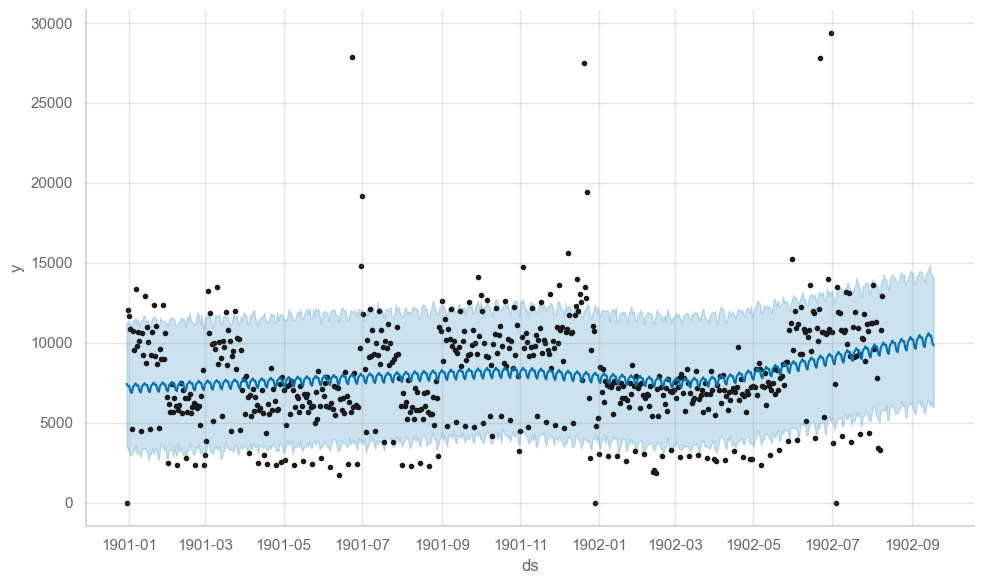

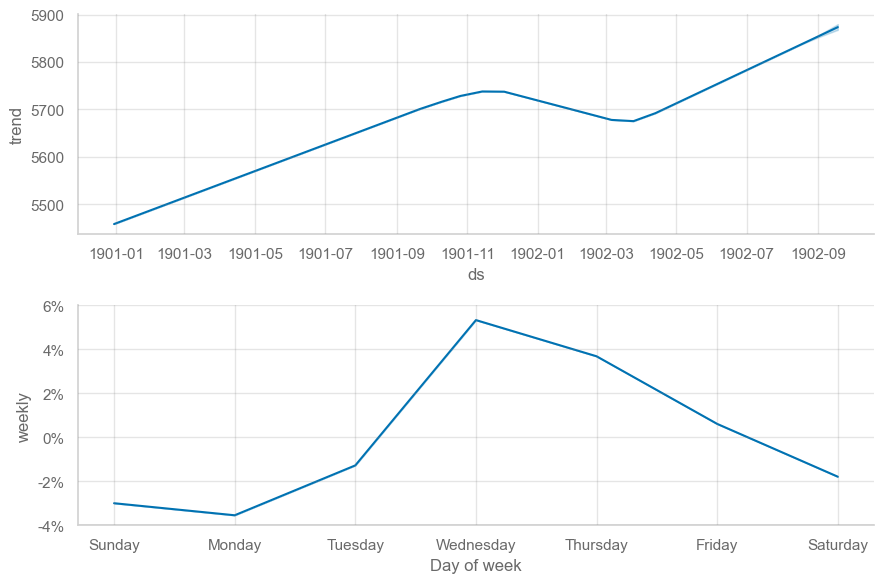

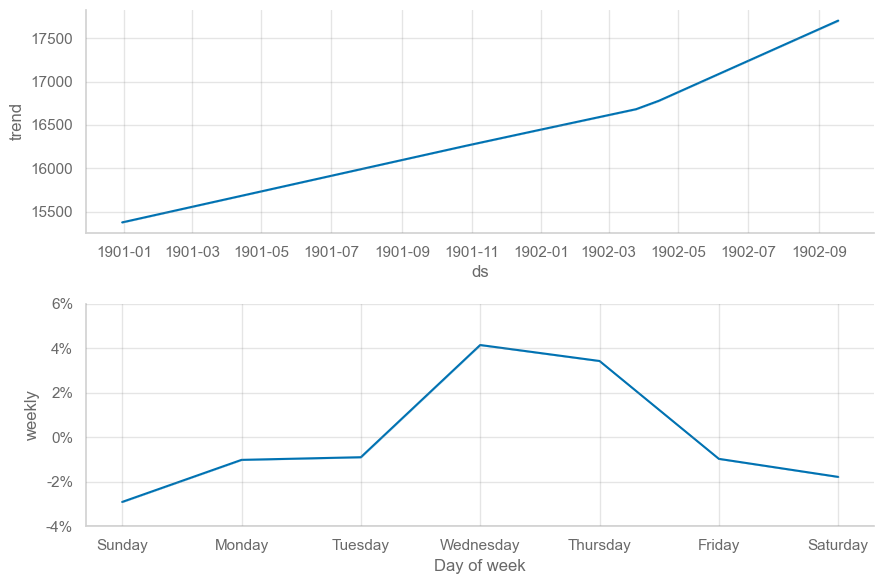

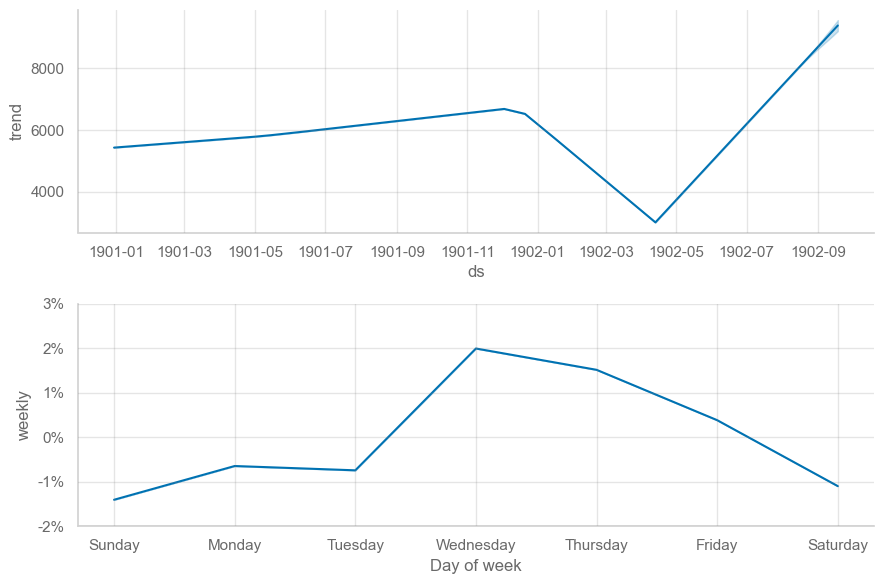

In [ ]:
#PROPHET MODEL

# Initialize an empty list to store the forecasted DataFrames
forecasted_dfs = []

# Iterate over the first 5 columns in the total_sales_df DataFrame
for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    # Filter the DataFrame to include only data before the forecast start date
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative'
                 )

# Fit the model to the data before the forecast start date
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
        # Make predictions for the future dates
    fcst_prophet_train = m.predict(future)
    
    # Plot the forecast and its components
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [ ]:
forecasted_df.head()

ds        trend   yhat_lower    yhat_upper  trend_lower  \
588 1902-08-10  8128.902926  5072.847115  10688.575462  8128.902926   
589 1902-08-11  8134.504485  5210.562405  10804.164583  8134.504485   
590 1902-08-12  8140.106044  5744.986278  11171.454869  8140.106044   
591 1902-08-13  8145.707603  5789.002355  11432.579619  8145.707603   
592 1902-08-14  8151.309161  5302.894541  10905.652474  8151.301719   

     trend_upper  multiplicative_terms  multiplicative_terms_lower  \
588  8128.902926             -0.024576                   -0.024576   
589  8134.504485             -0.014581                   -0.014581   
590  8140.106044              0.026623                    0.026623   
591  8145.707603              0.034840                    0.034840   
592  8151.309161             -0.000038                   -0.000038   

     multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
588                   -0.024576 -0.024576     -0.024576     -0.024576   
589                   -0.014581 -0.014581     -0.014581     -0.014581   
590                    0.026623  0.026623      0.026623      0.026623   
591                    0.034840  0.034840      0.034840      0.034840   
592                   -0.000038 -0.000038     -0.000038     -0.000038   

     additive_terms  additive_terms_lower  additive_terms_upper         yhat  
588             0.0                   0.0                   0.0  7929.126482  
589             0.0                   0.0                   0.0  8015.897458  
590             0.0                   0.0                   0.0  8356.821011  
591             0.0                   0.0                   0.0  8429.504149  
592             0.0                   0.0                   0.0  8151.002346

In [ ]:
import os

# Create a directory to store the models
os.makedirs('prophet_models', exist_ok=True)

# Save each model in the directory
for feature in total_sales_df.columns:
    joblib.dump(m, f'prophet_models/prophet_model_{feature}.joblib')
